<a href="https://colab.research.google.com/github/seschm/Internship-Gaertner/blob/main/Reproduction_training_states.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import jit, vmap, pmap, grad
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state
import optax
import torch.utils.data as data

from tqdm.auto import tqdm
import random as rng

import numpy as np
import scipy as sp
from numpy import sqrt, cos, sin, exp, pi, log2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import unitary_group
from scipy.stats import norm

In [ ]:
def generate_random_pure_state(nQubit):
    """
    Generates Haar random pure state.
    To generate a random pure state, take any basis state, e.g. |00...00>
    and apply a random unitary matrix. For consistency each basis state should be the same.
    """
    baseRho=np.zeros((2**nQubit,2**nQubit),dtype=complex)
    baseRho[0,0]=1
    U=unitary_group.rvs(2**nQubit)
    return U@baseRho@U.conj().T

In [ ]:
def generate_single_qubit(theta,phi):
    """
    Generates single qubit out of the given angles theta and phi.
    First construct the single qubit state as an array of shape (2, 1).
    Then compute the matrixproduct with its adjoint state.
    """
    state = np.array([[cos(theta/2)],[sin(theta/2)*exp(phi*1.j)]])
    return state@state.conj().T

In [ ]:
def generate_random_seperable_pure_state(nQubit):
    """
    Generates random seperable pure state.
    First generate the desired number of random pure states.
    Then tensor them together.
    """
    single_qubits = []
    for i in range(0,nQubit):
        single_qubits.append(generate_random_pure_state(1))
    tensored_qubits = [single_qubits[0]]
    for i in range(1,nQubit):
        tensored_qubits.append(np.kron(tensored_qubits[-1],single_qubits[i]))
    return tensored_qubits[-1]

In [ ]:
def depolarizing_channel(state,p):
    """
    Applies a depolarizing channel to the given state with p the probability of the completely mixed state.
    """
    d=len(state[0])
    return p*np.eye(d)/d+(1-p)*state

In [ ]:
def generate_POVM(theta,phi,nQubit):
    """
    Generates a POVM consisting of multi qubit projectors on to the axis defined by the two angles theta and phi.
    First generates all possible states (combinations of spin up and down) as strings containing 1s and 0s.
    The order is equal to binary counting.
    Then generates the single qubit projector and its orthogonal projector.
    In the next step all single qubit projectors corresponding to the same state are gathered in the correct order and then tensored together to get an element of the POVM.
    Returns the POVM with the elements beeing ordered equal to binary counting (-> up ... up, up ... up down, up ... up down up, ...).
    """
    up_and_downs = []

    for i in range(2**nQubit):
        binary = bin(i)[2:]
        zeros = np.zeros(nQubit-len(binary), dtype=int)
        for k in range(nQubit-len(binary)):
            binary = '0' + binary
        up_and_downs.append(binary)

    projector=generate_single_qubit(theta,phi)
    orthogonal_projector = np.eye(2)-projector
    POVM = []

    for i in range(2**nQubit):
        tensored_projector = []
        single_projectors = []
        for j in range(nQubit):
            if up_and_downs[i][j] == '0':
                single_projectors.append(projector)
            if up_and_downs[i][j] == '1':
                single_projectors.append(orthogonal_projector)
        tensored_projector.append(single_projectors[0])
        for k in range(nQubit-1):
            tensored_projector.append(np.kron(tensored_projector[-1],single_projectors[k+1]))
        POVM.append(tensored_projector[-1])

    return POVM

In [ ]:
def perform_multi_qubit_measurement(state,POVM):
    """
    Performs a multi qubit measurement with the given POVM.
    """
    probabilities = []
    for element in POVM:
        #probabilities.append(np.trace(element@state))
        probabilities.append(np.trace(np.einsum('ij,jk->ik',element,state,optimize=True)))
        #probabilities.append(np.einsum('ll',np.einsum('ij,jk->ik',element,state,optimize=True),optimize=True).real)
    return probabilities

In [ ]:
def perform_noisy_multi_qubit_measurement(state,POVM,p):
    """
    Generates probabilities of the noisy state.
    First applies the noise, then generates the probabilities.
    """
    noisy_state = depolarizing_channel(state,p)
    return perform_multi_qubit_measurement(noisy_state,POVM)

In [ ]:
def sampling(probabilities,samplesize):
    """
    Takes in a probability distribution and samples from it.
    """
    sampling = rng.choices(np.arange(0,len(probabilities)), weights=probabilities, k=samplesize)
    sampled_probabilities = []
    for element in np.arange(0,len(probabilities)):
        sampled_probabilities.append(sampling.count(element)/samplesize)
    return sampled_probabilities

In [ ]:
def MLE(nQubits,calibration_states,noisy_probabilities,POVM_ideal,p,samplesize):
    '''
    calibration_states: axis 0 = state, axis 1 = row, axis 2 = column
    noisy_probabilities: axis 0 = state, axis 1 = probabilities
    POVM_ideal / _reconstructed: axis 0 = element, axis 1 = row, axis 2 = column
    numb_of_detections: axis 0 = POVM_element, axis 1 = states, values = counts
    p_ideal: axis 0 = POVM_element, axis 1 = states, values = current ideal probability
    fracs: axis 0 = POVM_element, axis 1 = states, values = fractions

    '''

    numb_of_detections = noisy_probabilities.T * samplesize

    loop_num = 0
    loop_max = 2*10**3
    dist = 1
    dist_min = 10**-9

    POVM_reconstructed = np.array([p/2**nQubits*np.eye(2**nQubits) + (1-p)*POVM_elem for POVM_elem in POVM_ideal])

    while loop_num < loop_max and dist > dist_min:

        #p_ideal = np.array([perform_multi_qubit_measurement(state,POVM_reconstructed) for state in calibration_states]).T
        p_ideal = np.einsum('moll->mo',np.einsum('nij,ljk->nlik',POVM_reconstructed,calibration_states,optimize=True),optimize=True)
        #np.trace(element@state)
        #np.einsum('ll',np.einsum('ij,jk->ik',element,state,optimize=True),optimize=True).real
        fracs = numb_of_detections/p_ideal

        G = np.einsum('lm,ln,nij,ljk,mko->io',fracs,fracs,calibration_states,POVM_reconstructed,calibration_states,optimize=True)

        eig_vals,U = sp.linalg.eig(G)
        l_sqrt_inv = np.diag(1/np.sqrt(eig_vals))
        l_inv = U@l_sqrt_inv@U.conj().T # -> why not as in paper: U_dagger L_sqrt U ???

        R = np.einsum('ij,lm,mjk->lik',l_inv,fracs,calibration_states,optimize=True)

        POVM_reconstruction_old = POVM_reconstructed
        #POVM_reconstructed = np.einsum('lij,ljk,lkm->lim',R,POVM_reconstructed,R.conj().T)
        POVM_reconstructed = np.einsum('lij,ljk,lmk->lim',R,POVM_reconstructed,R.conj(),optimize=True)

        dist = np.sum([np.linalg.norm(POVM_reconstructed-POVM_reconstruction_old)])

        #if loop_num % (120/nQubit) == 0:
        if loop_num % 50 == 0:
            print(f'loop number: {loop_num}, distance: {dist}')

        loop_num += 1

    print(f'final loop number: {loop_num}, final distance: {dist}')

    return POVM_reconstructed, dist

In [ ]:
def loss_fn(state, params, batch_input, batch_target_output):
    predictions = state.apply_fn(params, batch_input)
    #loss = jnp.mean(optax.softmax_cross_entropy(predictions,batch_target_output))
    loss = jnp.mean(-jnp.sum(batch_target_output*jax.lax.log(predictions),axis=1))
    return loss

In [ ]:
@jax.jit
def accuracy_MSE(acc_input, acc_target_output,nQubit):
  acc = jnp.mean(jnp.sum(jnp.abs(acc_input-acc_target_output)**2,axis=-1)/(2**nQubit))
  return acc

In [ ]:
@jax.jit
def accuracy_KLD(acc_input, acc_target_output):
  acc = jnp.mean(jnp.sum(acc_target_output*jnp.log(acc_target_output/acc_input),axis=-1))
  return acc

In [ ]:
@jax.jit
def accuracy_IF(acc_input, acc_target_output):
  acc = jnp.mean(1-(jnp.sum(jnp.sqrt(acc_target_output*acc_input),axis=-1))**2)
  return acc

In [ ]:
def linear_inversion(nQubit,calibration_states,calibration_probabilities,POVM,p,samplesize,desired_probabilities,test_probs,desired_test_probs):
    '''

    '''

    POVM_recon, dist = MLE(nQubit,calibration_states,calibration_probabilities,POVM,p,samplesize)

    L = np.zeros((2**nQubit,2**nQubit))

    for i in range(2**nQubit):
        for j in range(2**nQubit):
            L[j][i] = POVM_recon[i][j][j]

    L_inv = np.linalg.inv(L)

    probs_cor = np.einsum('ij,lj->li',L_inv,test_probs,optimize=True)
    probs_cor_tr = np.einsum('ij,lj->li',L_inv,calibration_probabilities,optimize=True)

    acc_MSE = accuracy_MSE(probs_cor, desired_test_probs,nQubit)
    acc_MSE_tr = accuracy_MSE(probs_cor_tr, desired_probabilities,nQubit)

    acc_KLD = accuracy_KLD(probs_cor, desired_test_probs)
    acc_KLD_tr = accuracy_KLD(probs_cor_tr, desired_probabilities)

    acc_IF = accuracy_IF(probs_cor, desired_test_probs)
    acc_IF_tr = accuracy_IF(probs_cor_tr, desired_probabilities)

    return L_inv, POVM_recon, probs_cor, [acc_MSE,acc_MSE_tr], [acc_KLD,acc_KLD_tr], [acc_IF,acc_IF_tr]

In [ ]:
@jax.jit  # Jit the function for efficiency
def train_step(state, batch_input, batch_target_output):
    # Gradient function
    grad_fn = jax.value_and_grad(loss_fn,# Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                )
    # Determine gradients for current model, parameters and batch
    loss, grads = grad_fn(state, state.params, batch_input, batch_target_output)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss

In [ ]:
def train_model(state, batched_training_input, batched_training_target_outputs, acc_input, acc_target_output,nQubit, num_epochs = 100):

  acc_test_MSE = []
  acc_training_MSE = []
  acc_unmitigated_test_MSE = []

  acc_test_KLD = []
  acc_training_KLD = []
  acc_unmitigated_test_KLD = []

  acc_test_IF = []
  acc_training_IF = []
  acc_unmitigated_test_IF = []

  for epoch in tqdm(range(num_epochs)):
    for i in range(len(batched_training_input)):
      state, loss = train_step(state, batched_training_input[i], batched_training_target_outputs[i])

    predictions_test = state.apply_fn(state.params, acc_input)
    predictions_training = state.apply_fn(state.params, batched_training_input)

    acc_test_MSE.append(accuracy_MSE(predictions_test, acc_target_output,nQubit))
    acc_training_MSE.append(accuracy_MSE(predictions_training, batched_training_target_outputs,nQubit))
    acc_unmitigated_test_MSE.append(accuracy_MSE(acc_input, acc_target_output,nQubit))

    acc_test_KLD.append(accuracy_KLD(predictions_test, acc_target_output))
    acc_training_KLD.append(accuracy_KLD(predictions_training, batched_training_target_outputs))
    acc_unmitigated_test_KLD.append(accuracy_KLD(acc_input, acc_target_output))

    acc_test_IF.append(accuracy_IF(predictions_test, acc_target_output))
    acc_training_IF.append(accuracy_IF(predictions_training, batched_training_target_outputs))
    acc_unmitigated_test_IF.append(accuracy_IF(acc_input, acc_target_output))

  return state, [acc_test_MSE, acc_training_MSE, acc_unmitigated_test_MSE], [acc_test_KLD, acc_training_KLD, acc_unmitigated_test_KLD], [acc_test_IF, acc_training_IF, acc_unmitigated_test_IF]

In [ ]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

In [ ]:
class MLP(nn.Module):

  num_neurons_per_layer : list[int]   # List containing the number of neurons per layer (except input layer)


  @nn.compact
  def __call__(self, x):
    activation = x
    for i, numb_neurons in enumerate(self.num_neurons_per_layer):
      activation = nn.Dense(numb_neurons)(activation) # tell how to initialize weigths -> reduce variance
      if i != len(self.num_neurons_per_layer) - 1:
        activation = nn.relu(activation)
    return jax.nn.softmax(activation)

  0%|          | 0/36 [00:00<?, ?it/s]

/usr/lib/python3.10/random.py:536: ComplexWarning: Casting complex values to real discards the imaginary part
  if not _isfinite(total):
<ipython-input-20-6551190eca98>:49: ComplexWarning: Casting complex values to real discards the imaginary part
  training_data[i][j+2**nQubit] = probs[j]
<ipython-input-20-6551190eca98>:70: ComplexWarning: Casting complex values to real discards the imaginary part
  test_data[i][j+2**nQubit] = probs[j]


loop number: 0, distance: 0.009473204987996328
loop number: 50, distance: 9.668704511227273e-05
loop number: 100, distance: 2.5181515345512336e-05
loop number: 150, distance: 7.474490134962251e-06
loop number: 200, distance: 2.300894306871469e-06
loop number: 250, distance: 7.159125439243404e-07
loop number: 300, distance: 2.2351762532408e-07
loop number: 350, distance: 6.986970319893139e-08
loop number: 400, distance: 2.1850416020490988e-08
loop number: 450, distance: 6.834338770613914e-09
loop number: 500, distance: 2.1377024791561724e-09
final loop number: 534, final distance: 9.926803866264963e-10


<ipython-input-15-ea805b2e5879>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  L[j][i] = POVM_recon[i][j][j]


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0057723378963421374
loop number: 50, distance: 2.2956041785683073e-05
loop number: 100, distance: 2.1793427516060968e-06
loop number: 150, distance: 2.6608282836735004e-07
loop number: 200, distance: 3.7850795731134994e-08
loop number: 250, distance: 5.877429608899757e-09
final loop number: 300, final distance: 9.867459171353356e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.004269798490473994
loop number: 50, distance: 3.1066843195543095e-05
loop number: 100, distance: 2.6872711526971645e-06
loop number: 150, distance: 2.850270889079425e-07
loop number: 200, distance: 3.204032944622061e-08
loop number: 250, distance: 3.6803510064446377e-09
final loop number: 282, final distance: 9.6811788265552e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.004546494436331976
loop number: 50, distance: 2.3634516738190327e-05
loop number: 100, distance: 2.7407104241318513e-06
loop number: 150, distance: 3.5014627350924344e-07
loop number: 200, distance: 4.570557527113482e-08
loop number: 250, distance: 6.014163898621344e-09
final loop number: 296, final distance: 9.721973531926733e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0034387599473635396
loop number: 50, distance: 2.0309533665619598e-05
loop number: 100, distance: 1.998800924733374e-06
loop number: 150, distance: 2.0776513139284182e-07
loop number: 200, distance: 2.1765400256533892e-08
loop number: 250, distance: 2.2930392113079464e-09
final loop number: 270, final distance: 9.762753722130877e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0036665105243156677
loop number: 50, distance: 1.621552636052515e-05
loop number: 100, distance: 1.7697840901031613e-06
loop number: 150, distance: 2.0845132577384917e-07
loop number: 200, distance: 2.519335244148188e-08
loop number: 250, distance: 3.0798523027103786e-09
final loop number: 278, final distance: 9.924175545934733e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.003106016374255486
loop number: 50, distance: 2.000181600292917e-05
loop number: 100, distance: 2.0293918529849724e-06
loop number: 150, distance: 2.1105515475211905e-07
loop number: 200, distance: 2.19876077572209e-08
loop number: 250, distance: 2.292226491525273e-09
final loop number: 270, final distance: 9.70936517206473e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0028827970041704425
loop number: 50, distance: 9.713641834725008e-06
loop number: 100, distance: 9.170746879244972e-07
loop number: 150, distance: 9.414003192211861e-08
loop number: 200, distance: 1.0070802544839576e-08
loop number: 250, distance: 1.1020741813421863e-09
final loop number: 254, final distance: 9.655073668395596e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0030449456346721172
loop number: 50, distance: 9.83206462174577e-06
loop number: 100, distance: 8.094819327651409e-07
loop number: 150, distance: 7.08837357219795e-08
loop number: 200, distance: 6.303293530500803e-09
final loop number: 240, final distance: 9.631899223699328e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.002459170297189855
loop number: 50, distance: 3.968206663086847e-06
loop number: 100, distance: 3.3875075602327745e-07
loop number: 150, distance: 3.563972239168424e-08
loop number: 200, distance: 3.8291807711232345e-09
final loop number: 232, final distance: 9.661313344419169e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0023873876393772243
loop number: 50, distance: 8.701869439998228e-06
loop number: 100, distance: 6.872437347801981e-07
loop number: 150, distance: 5.985662353084804e-08
loop number: 200, distance: 5.480460522306051e-09
final loop number: 238, final distance: 9.556485246961508e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0025055588564428938
loop number: 50, distance: 1.0626923942582112e-05
loop number: 100, distance: 9.378585540706533e-07
loop number: 150, distance: 8.802053383241283e-08
loop number: 200, distance: 8.361619974369204e-09
final loop number: 247, final distance: 9.676036940933305e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.002937908267264041
loop number: 50, distance: 6.25897335040394e-06
loop number: 100, distance: 5.024501091718181e-07
loop number: 150, distance: 4.4863671918303274e-08
loop number: 200, distance: 4.08880227817322e-09
final loop number: 231, final distance: 9.793282874015813e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0020482078829093466
loop number: 50, distance: 5.92475501460326e-06
loop number: 100, distance: 5.103888036062546e-07
loop number: 150, distance: 4.449157505045016e-08
loop number: 200, distance: 3.9084954411203635e-09
final loop number: 230, final distance: 9.571667333764812e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0024594768815202426
loop number: 50, distance: 5.4546900859748045e-06
loop number: 100, distance: 3.446410286846605e-07
loop number: 150, distance: 2.585632320033369e-08
loop number: 200, distance: 2.0872566802312265e-09
final loop number: 216, final distance: 9.95475644627819e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0025105277224934074
loop number: 50, distance: 7.526263751141724e-06
loop number: 100, distance: 6.784973395490092e-07
loop number: 150, distance: 6.443526746133579e-08
loop number: 200, distance: 6.136005588378016e-09
final loop number: 240, final distance: 9.812103633340885e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.002462162878293297
loop number: 50, distance: 7.901920300480223e-06
loop number: 100, distance: 6.839493031715035e-07
loop number: 150, distance: 6.292379329820474e-08
loop number: 200, distance: 5.8356259260159924e-09
final loop number: 239, final distance: 9.618750407256692e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0016534960063470019
loop number: 50, distance: 1.0454146267005772e-05
loop number: 100, distance: 9.236867007182284e-07
loop number: 150, distance: 8.22351902702895e-08
loop number: 200, distance: 7.339458966179678e-09
final loop number: 243, final distance: 9.662008512989003e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0018171110678895297
loop number: 50, distance: 3.108124592519064e-06
loop number: 100, distance: 2.3096770777084713e-07
loop number: 150, distance: 2.0833000921116466e-08
loop number: 200, distance: 1.8916832507467936e-09
final loop number: 215, final distance: 9.666030774107247e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0019354789730495108
loop number: 50, distance: 6.728563961045004e-06
loop number: 100, distance: 5.677416430019024e-07
loop number: 150, distance: 4.9380933692971444e-08
loop number: 200, distance: 4.3192145607825295e-09
final loop number: 232, final distance: 9.55953225917714e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0017116918737145293
loop number: 50, distance: 5.5440874730126654e-06
loop number: 100, distance: 5.102758562307229e-07
loop number: 150, distance: 4.93414803792996e-08
loop number: 200, distance: 4.846272448596133e-09
final loop number: 236, final distance: 9.614599980202198e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0016753897025860124
loop number: 50, distance: 1.541636100596265e-06
loop number: 100, distance: 8.858364812920958e-08
loop number: 150, distance: 7.594264342293452e-09
final loop number: 193, final distance: 9.908041577200492e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0015361247843981155
loop number: 50, distance: 4.671705413178383e-06
loop number: 100, distance: 3.8286615632605577e-07
loop number: 150, distance: 3.312514453880067e-08
loop number: 200, distance: 2.869608442382825e-09
final loop number: 223, final distance: 9.782114292119624e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0014463674307076883
loop number: 50, distance: 7.858116928948508e-06
loop number: 100, distance: 6.658747329054002e-07
loop number: 150, distance: 5.746688343424911e-08
loop number: 200, distance: 4.966188761480769e-09
final loop number: 234, final distance: 9.873206157874398e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0018710764936371589
loop number: 50, distance: 5.853433678894302e-06
loop number: 100, distance: 5.92475495529707e-07
loop number: 150, distance: 6.144527652424766e-08
loop number: 200, distance: 6.378429208420789e-09
final loop number: 242, final distance: 9.958056266236566e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0012433404025484422
loop number: 50, distance: 4.361261776073463e-06
loop number: 100, distance: 3.4643089031168267e-07
loop number: 150, distance: 2.947122430378326e-08
loop number: 200, distance: 2.531339405199698e-09
final loop number: 220, final distance: 9.986156600526144e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0020316990656273257
loop number: 50, distance: 6.373062973537312e-06
loop number: 100, distance: 5.568270122162059e-07
loop number: 150, distance: 5.044843934876897e-08
loop number: 200, distance: 4.6612307330815156e-09
final loop number: 234, final distance: 9.778583584309344e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.001446854577134858
loop number: 50, distance: 2.53667717431591e-06
loop number: 100, distance: 1.8248849087433114e-07
loop number: 150, distance: 1.5618895515634548e-08
loop number: 200, distance: 1.3430115254082852e-09
final loop number: 208, final distance: 9.526493877293044e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.001830482057718519
loop number: 50, distance: 3.7237548333822856e-06
loop number: 100, distance: 3.2067575338943344e-07
loop number: 150, distance: 2.838402159184958e-08
loop number: 200, distance: 2.5356045958899766e-09
final loop number: 221, final distance: 9.672686526282377e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0012754082091174148
loop number: 50, distance: 5.884938335729686e-06
loop number: 100, distance: 4.990175486491576e-07
loop number: 150, distance: 4.569220735488321e-08
loop number: 200, distance: 4.214354577174381e-09
final loop number: 232, final distance: 9.640689693048797e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0018238002657080651
loop number: 50, distance: 2.9877736151603964e-06
loop number: 100, distance: 2.398764246843267e-07
loop number: 150, distance: 2.0369142341535593e-08
loop number: 200, distance: 1.7354102283641779e-09
final loop number: 213, final distance: 9.613132980701749e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.001632530885531861
loop number: 50, distance: 3.837531434616682e-06
loop number: 100, distance: 3.337656959356769e-07
loop number: 150, distance: 3.073164355168688e-08
loop number: 200, distance: 2.847653687854541e-09
final loop number: 224, final distance: 9.551960780958014e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0012706567185153614
loop number: 50, distance: 4.389367582154237e-06
loop number: 100, distance: 3.765681739423039e-07
loop number: 150, distance: 3.404712242927746e-08
loop number: 200, distance: 3.1198310259932924e-09
final loop number: 225, final distance: 9.9506004480357e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.002057243547843738
loop number: 50, distance: 6.27074782893325e-06
loop number: 100, distance: 5.039409729417526e-07
loop number: 150, distance: 4.227687969861181e-08
loop number: 200, distance: 3.564385096549745e-09
final loop number: 227, final distance: 9.868327818109252e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0015672234873032095
loop number: 50, distance: 6.905207601797454e-06
loop number: 100, distance: 6.223243911831793e-07
loop number: 150, distance: 6.016595281322402e-08
loop number: 200, distance: 5.882704235126747e-09
final loop number: 240, final distance: 9.640868376896898e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0011143501521646915
loop number: 50, distance: 7.981360097136224e-06
loop number: 100, distance: 7.050708444829578e-07
loop number: 150, distance: 6.593099166842705e-08
loop number: 200, distance: 6.2498083872124104e-09
final loop number: 241, final distance: 9.546811997022402e-10


  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0.98, 'Accuracy depending on number of training states')

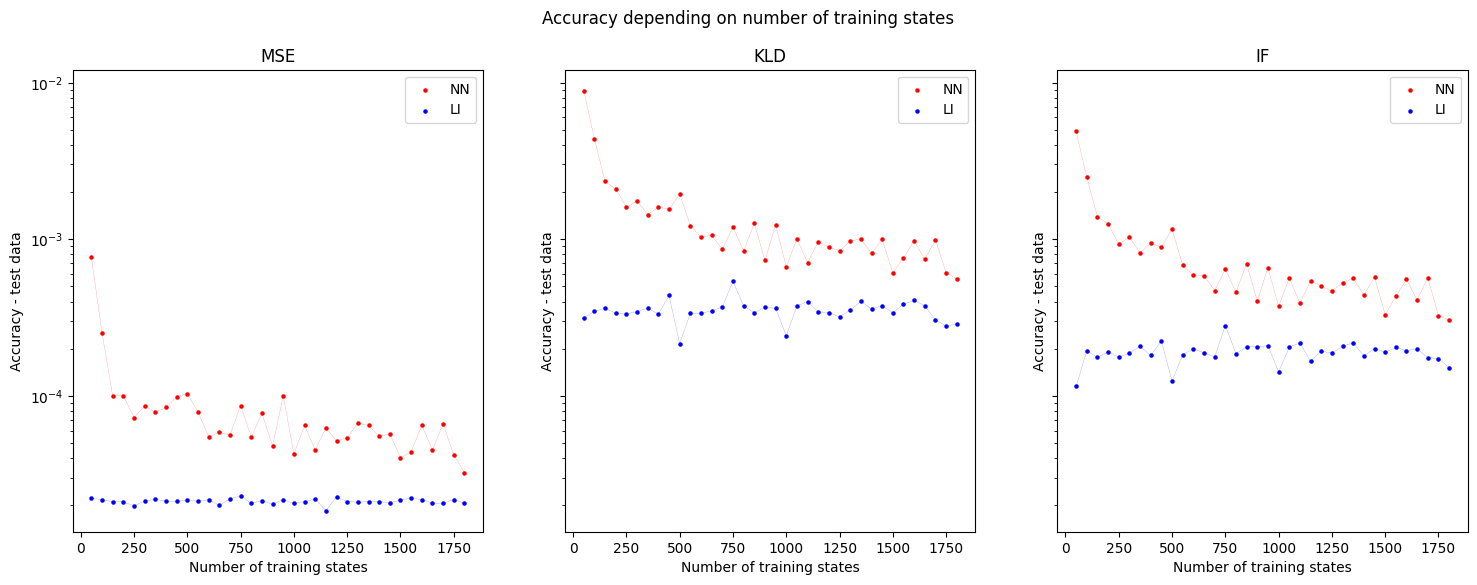

In [ ]:
nQubit = 2
layers = [20,20,20,20,20,2**nQubit]
num_epochs = 300
batch_size = 50
learning_rate = 0.001
test_states = 500
test_data = np.zeros((test_states,2**nQubit*2))
theta = 0
phi = 0
p = 0.15
samplesize = 10000

model = MLP(num_neurons_per_layer=layers)        # Initialize network
x_key, init_key = random.split(random.PRNGKey(0))
x = random.normal(x_key, (batch_size, 2**nQubit))                    # Batch size 100, input size 2
params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)

optimizer = optax.adam(learning_rate=learning_rate) #sgd
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

POVM = generate_POVM(theta,phi,nQubit)


training_states = np.arange(50,1850,50)
accuracies = []

for numb in tqdm(training_states):
    training_data = np.zeros((numb,2**nQubit*2))

    calibration_states_list = []
    calibration_probs_list = []
    desired_probs_list = []
    test_probs_list = []
    desired_test_probs_list = []

    for i in range(numb):
        state = generate_random_seperable_pure_state(nQubit)
        calibration_states_list.append(state)
        probs = perform_multi_qubit_measurement(state,POVM)
        noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
        noisy_probs_sampled = sampling(noisy_probs,samplesize)
        calibration_probs_list.append(noisy_probs_sampled)
        desired_probs_list.append(probs)
        for j in range(2**nQubit):
            training_data[i][j] = noisy_probs_sampled[j]
            #training_data[i][j] = noisy_probs[j]
            training_data[i][j+2**nQubit] = probs[j]

    data_loader_training = data.DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
    batched_training_input = []
    batched_training_target_outputs = []

    for batch in data_loader_training:
        inputs, targets = jnp.split(batch,2,axis=1)
        batched_training_input.append(inputs)
        batched_training_target_outputs.append(targets)

    for i in range(test_states):
        state = generate_random_seperable_pure_state(nQubit)
        probs = perform_multi_qubit_measurement(state,POVM)
        noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
        noisy_probs_sampled = sampling(noisy_probs,samplesize)
        test_probs_list.append(noisy_probs_sampled)
        desired_test_probs_list.append(probs)
        for j in range(2**nQubit):
            test_data[i][j] = noisy_probs_sampled[j]
            #test_data[i][j] = noisy_probs[j]
            test_data[i][j+2**nQubit] = probs[j]

    data_loader_test = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
    batched_test_input = []
    batched_test_target_outputs = []

    for batch in data_loader_test:
        inputs, targets = jnp.split(batch,2,axis=1)
        batched_test_input.append(inputs)
        batched_test_target_outputs.append(targets)

    batched_tr_inp = jnp.asarray(batched_training_input)
    batched_tr_tar_out = jnp.asarray(batched_training_target_outputs)
    batched_test_inp = jnp.asarray(batched_test_input)
    batched_test_tar_out = jnp.asarray(batched_test_target_outputs)

    calibration_states = np.asarray(calibration_states_list)
    calibration_probs = np.asarray(calibration_probs_list)
    desired_probs = np.asarray(desired_probs_list)
    test_probs = np.asarray(test_probs_list)
    desired_test = np.asarray(desired_test_probs_list)

    L_inv2, POVM2, P2, MSE_data_LI2, KLD_data_LI2, IF_data_LI2 = linear_inversion(nQubit,calibration_states,calibration_probs,POVM,p,samplesize,desired_probs,test_probs,desired_test)
    trained_model_state2, MSE_data2, KLD_data2, IF_data2 = train_model(model_state, batched_tr_inp, batched_tr_tar_out,
                                                                  batched_test_inp, batched_test_tar_out,
                                                                  nQubit=nQubit, num_epochs = num_epochs)

    accuracies.append([[MSE_data2,MSE_data_LI2],[KLD_data2,KLD_data_LI2],[IF_data2,IF_data_LI2]])

MSE_acc2 = []
MSE_acc_LI2 = []
KLD_acc2 = []
KLD_acc_LI2 = []
IF_acc2 = []
IF_acc_LI2 = []

for element in accuracies:
    MSE_acc2.append(element[0][0][0][-1])
    MSE_acc_LI2.append(element[0][1][0])
    KLD_acc2.append(element[1][0][0][-1])
    KLD_acc_LI2.append(element[1][1][0])
    IF_acc2.append(element[2][0][0][-1])
    IF_acc_LI2.append(element[2][1][0])

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axs[0].scatter(training_states,MSE_acc2,s=5,label="NN",color="red")
axs[0].plot(training_states,MSE_acc2,color="red",linewidth=0.1)
axs[0].scatter(training_states,MSE_acc_LI2,s=5,label="LI",color="blue")
axs[0].plot(training_states,MSE_acc_LI2,color="blue",linewidth=0.1)
axs[0].set_xlabel('Number of training states')
axs[0].set_ylabel('Accuracy - test data')
axs[0].set_yscale('log')
axs[0].set_title('MSE')
axs[0].legend()
axs[1].scatter(training_states,KLD_acc2,s=5,label="NN",color="red")
axs[1].plot(training_states,KLD_acc2,color="red",linewidth=0.1)
axs[1].scatter(training_states,KLD_acc_LI2,s=5,label="LI",color="blue")
axs[1].plot(training_states,KLD_acc_LI2,color="blue",linewidth=0.1)
axs[1].set_xlabel('Number of training states')
axs[1].set_ylabel('Accuracy - test data')
axs[1].set_yscale('log')
axs[1].set_title('KLD')
axs[1].legend()
axs[2].scatter(training_states,IF_acc2,s=5,label="NN",color="red")
axs[2].plot(training_states,IF_acc2,color="red",linewidth=0.1)
axs[2].scatter(training_states,IF_acc_LI2,s=5,label="LI",color="blue")
axs[2].plot(training_states,IF_acc_LI2,color="blue",linewidth=0.1)
axs[2].set_xlabel('Number of training states')
axs[2].set_ylabel('Accuracy - test data')
axs[2].set_yscale('log')
axs[2].set_title('IF')
axs[2].legend()
fig.suptitle('Accuracy depending on number of training states')

  0%|          | 0/39 [00:00<?, ?it/s]

<ipython-input-21-53fa344d7544>:49: ComplexWarning: Casting complex values to real discards the imaginary part
  training_data[i][j+2**nQubit] = probs[j]
<ipython-input-21-53fa344d7544>:70: ComplexWarning: Casting complex values to real discards the imaginary part
  test_data[i][j+2**nQubit] = probs[j]


loop number: 0, distance: 0.01709307391611465
loop number: 50, distance: 0.0004595942519994619
loop number: 100, distance: 0.0002541035041680459
loop number: 150, distance: 0.0001758378453569105
loop number: 200, distance: 0.0001343177676277231
loop number: 250, distance: 0.00010811281511768152
loop number: 300, distance: 8.968784517031878e-05
loop number: 350, distance: 7.582709956456771e-05
loop number: 400, distance: 6.494768118564722e-05
loop number: 450, distance: 5.6170112751813514e-05
loop number: 500, distance: 4.8953976201518605e-05
loop number: 550, distance: 4.2940017635384986e-05
loop number: 600, distance: 3.787503695260126e-05
loop number: 650, distance: 3.357285131403194e-05
loop number: 700, distance: 2.989228527418702e-05
loop number: 750, distance: 2.6723838528407227e-05
loop number: 800, distance: 2.3981107160700818e-05
loop number: 850, distance: 2.1594986090742962e-05
loop number: 900, distance: 1.9509596019054676e-05
loop number: 950, distance: 1.7679333877261126e

<ipython-input-15-ea805b2e5879>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  L[j][i] = POVM_recon[i][j][j]


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.012390916002942435
loop number: 50, distance: 0.0002825294151929076
loop number: 100, distance: 0.0001385243214633889
loop number: 150, distance: 8.351860886653893e-05
loop number: 200, distance: 5.4265262498832495e-05
loop number: 250, distance: 3.666040307929613e-05
loop number: 300, distance: 2.5381827025804624e-05
loop number: 350, distance: 1.787283117689516e-05
loop number: 400, distance: 1.274018461698303e-05
loop number: 450, distance: 9.164497866894896e-06
loop number: 500, distance: 6.638018343904322e-06
loop number: 550, distance: 4.833696025371613e-06
loop number: 600, distance: 3.534515604814128e-06
loop number: 650, distance: 2.593096005608737e-06
loop number: 700, distance: 1.9075100383906687e-06
loop number: 750, distance: 1.4062526048160407e-06
loop number: 800, distance: 1.0385945526055094e-06
loop number: 850, distance: 7.682262266852311e-07
loop number: 900, distance: 5.68975794728175e-07
loop number: 950, distance: 4.2187274944985885e-07

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.00924172193978044
loop number: 50, distance: 0.00021788351719088378
loop number: 100, distance: 8.632430135252794e-05
loop number: 150, distance: 4.240407789377092e-05
loop number: 200, distance: 2.3016028993038684e-05
loop number: 250, distance: 1.321464215899367e-05
loop number: 300, distance: 7.859729556951567e-06
loop number: 350, distance: 4.789488751872264e-06
loop number: 400, distance: 2.9716673588011553e-06
loop number: 450, distance: 1.870326966616695e-06
loop number: 500, distance: 1.1911964664070724e-06
loop number: 550, distance: 7.663783870531906e-07
loop number: 600, distance: 4.974060276887821e-07
loop number: 650, distance: 3.253125335410276e-07
loop number: 700, distance: 2.1418678300753866e-07
loop number: 750, distance: 1.4184582660299412e-07
loop number: 800, distance: 9.441567835341653e-08
loop number: 850, distance: 6.312252636487684e-08
loop number: 900, distance: 4.2362418348658256e-08
loop number: 950, distance: 2.852386262548341e-0

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.008396552177356381
loop number: 50, distance: 0.00018805572093016242
loop number: 100, distance: 7.806001757694151e-05
loop number: 150, distance: 3.919808070036748e-05
loop number: 200, distance: 2.127739187530447e-05
loop number: 250, distance: 1.2024914374955064e-05
loop number: 300, distance: 6.9606728681610866e-06
loop number: 350, distance: 4.0934554585229385e-06
loop number: 400, distance: 2.4345911770962797e-06
loop number: 450, distance: 1.460363363950295e-06
loop number: 500, distance: 8.819110699177147e-07
loop number: 550, distance: 5.355545650987424e-07
loop number: 600, distance: 3.267714655030474e-07
loop number: 650, distance: 2.002144642102231e-07
loop number: 700, distance: 1.2313296179956822e-07
loop number: 750, distance: 7.598739210901521e-08
loop number: 800, distance: 4.70421240041401e-08
loop number: 850, distance: 2.9209187984581596e-08
loop number: 900, distance: 1.8186987370987178e-08
loop number: 950, distance: 1.1353783665376929e

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.008187316721995913
loop number: 50, distance: 0.00016158343466828178
loop number: 100, distance: 6.433159617170395e-05
loop number: 150, distance: 2.9998325662932907e-05
loop number: 200, distance: 1.4978823513630822e-05
loop number: 250, distance: 7.776137695998661e-06
loop number: 300, distance: 4.1419365536753995e-06
loop number: 350, distance: 2.247394221850788e-06
loop number: 400, distance: 1.2366511580005775e-06
loop number: 450, distance: 6.879745651221553e-07
loop number: 500, distance: 3.860823974520166e-07
loop number: 550, distance: 2.1818794733388126e-07
loop number: 600, distance: 1.2400837633670713e-07
loop number: 650, distance: 7.080917464472341e-08
loop number: 700, distance: 4.0587117574026326e-08
loop number: 750, distance: 2.333786755309708e-08
loop number: 800, distance: 1.3454856092106674e-08
loop number: 850, distance: 7.774224483869802e-09
loop number: 900, distance: 4.500343204247904e-09
loop number: 950, distance: 2.60929453368766e

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.007431015432214334
loop number: 50, distance: 0.00014995009497373207
loop number: 100, distance: 5.775535235283846e-05
loop number: 150, distance: 2.64486214968235e-05
loop number: 200, distance: 1.286693246876715e-05
loop number: 250, distance: 6.455236855053641e-06
loop number: 300, distance: 3.299934332050436e-06
loop number: 350, distance: 1.7086371605453223e-06
loop number: 400, distance: 8.930616104703026e-07
loop number: 450, distance: 4.702189411101613e-07
loop number: 500, distance: 2.490625880684486e-07
loop number: 550, distance: 1.3258148545809802e-07
loop number: 600, distance: 7.087721660898216e-08
loop number: 650, distance: 3.803064846030434e-08
loop number: 700, distance: 2.0472332161411935e-08
loop number: 750, distance: 1.1052149312204717e-08
loop number: 800, distance: 5.9818953038774645e-09
loop number: 850, distance: 3.24512782915779e-09
loop number: 900, distance: 1.7641300257983577e-09
final loop number: 948, final distance: 9.9647149

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.007191495816577925
loop number: 50, distance: 0.0001314961171197226
loop number: 100, distance: 4.861690649601461e-05
loop number: 150, distance: 2.1292756074262763e-05
loop number: 200, distance: 9.972336278675013e-06
loop number: 250, distance: 4.839350920301308e-06
loop number: 300, distance: 2.399257444575936e-06
loop number: 350, distance: 1.2060249785382604e-06
loop number: 400, distance: 6.11909221663148e-07
loop number: 450, distance: 3.125282441709722e-07
loop number: 500, distance: 1.6040674188473142e-07
loop number: 550, distance: 8.264290041143841e-08
loop number: 600, distance: 4.270827301807706e-08
loop number: 650, distance: 2.2126426424051808e-08
loop number: 700, distance: 1.1487697865005419e-08
loop number: 750, distance: 5.975115497690158e-09
loop number: 800, distance: 3.1127707253278543e-09
loop number: 850, distance: 1.623869799332908e-09
final loop number: 889, final distance: 9.911459560290022e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.005614638243139862
loop number: 50, distance: 0.00012282043773818798
loop number: 100, distance: 4.3852136127473076e-05
loop number: 150, distance: 1.856061353786939e-05
loop number: 200, distance: 8.392418238601999e-06
loop number: 250, distance: 3.937215782175654e-06
loop number: 300, distance: 1.8912432410979594e-06
loop number: 350, distance: 9.230928556409512e-07
loop number: 400, distance: 4.5559787495616874e-07
loop number: 450, distance: 2.266585799792511e-07
loop number: 500, distance: 1.134191525936109e-07
loop number: 550, distance: 5.7001867130396365e-08
loop number: 600, distance: 2.8743492577488703e-08
loop number: 650, distance: 1.4532047429909002e-08
loop number: 700, distance: 7.362534632578618e-09
loop number: 750, distance: 3.736605030941205e-09
loop number: 800, distance: 1.8991258668162495e-09
final loop number: 849, final distance: 9.928640778186197e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.006147760230297031
loop number: 50, distance: 0.00012324235065866432
loop number: 100, distance: 4.823062324257061e-05
loop number: 150, distance: 2.1317580722676424e-05
loop number: 200, distance: 9.873202077805015e-06
loop number: 250, distance: 4.707087392536255e-06
loop number: 300, distance: 2.290801810275287e-06
loop number: 350, distance: 1.131932852348929e-06
loop number: 400, distance: 5.657171854008814e-07
loop number: 450, distance: 2.851932018340998e-07
loop number: 500, distance: 1.4474056907228165e-07
loop number: 550, distance: 7.384854243774e-08
loop number: 600, distance: 3.784008699814192e-08
loop number: 650, distance: 1.945795114107697e-08
loop number: 700, distance: 1.0035425571184594e-08
loop number: 750, distance: 5.189018987027788e-09
loop number: 800, distance: 2.6890815609455236e-09
loop number: 850, distance: 1.3963048289572177e-09
final loop number: 877, final distance: 9.937662902308067e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.005235159687471409
loop number: 50, distance: 0.00010104821550368654
loop number: 100, distance: 3.850990460500815e-05
loop number: 150, distance: 1.700665556346371e-05
loop number: 200, distance: 7.849922722233269e-06
loop number: 250, distance: 3.702351314318446e-06
loop number: 300, distance: 1.7693247800443255e-06
loop number: 350, distance: 8.532335179263065e-07
loop number: 400, distance: 4.142074225751478e-07
loop number: 450, distance: 2.0210752130312046e-07
loop number: 500, distance: 9.901362101423917e-08
loop number: 550, distance: 4.866536273649756e-08
loop number: 600, distance: 2.398340642387441e-08
loop number: 650, distance: 1.184631515548155e-08
loop number: 700, distance: 5.862701307787789e-09
loop number: 750, distance: 2.9063503961951935e-09
loop number: 800, distance: 1.4429526689484555e-09
final loop number: 828, final distance: 9.8921293318672e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.004774514017472661
loop number: 50, distance: 0.00010099207682654848
loop number: 100, distance: 3.5877350117028647e-05
loop number: 150, distance: 1.4942812733303688e-05
loop number: 200, distance: 6.558059304055461e-06
loop number: 250, distance: 2.954236127925759e-06
loop number: 300, distance: 1.3529973316631005e-06
loop number: 350, distance: 6.271517609843994e-07
loop number: 400, distance: 2.934758892633028e-07
loop number: 450, distance: 1.3842068834802818e-07
loop number: 500, distance: 6.573263306857259e-08
loop number: 550, distance: 3.140252412578884e-08
loop number: 600, distance: 1.5082939545203874e-08
loop number: 650, distance: 7.280053415692046e-09
loop number: 700, distance: 3.529693851342652e-09
loop number: 750, distance: 1.718486360637499e-09
final loop number: 789, final distance: 9.9702321389033e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.005399792614709795
loop number: 50, distance: 9.167279468972025e-05
loop number: 100, distance: 3.214928451772944e-05
loop number: 150, distance: 1.3181696883837271e-05
loop number: 200, distance: 5.673556730792119e-06
loop number: 250, distance: 2.5012390917190504e-06
loop number: 300, distance: 1.119498961112558e-06
loop number: 350, distance: 5.064365804798464e-07
loop number: 400, distance: 2.3093646406432182e-07
loop number: 450, distance: 1.0596236388289361e-07
loop number: 500, distance: 4.886072920733968e-08
loop number: 550, distance: 2.2621706021318186e-08
loop number: 600, distance: 1.0508948988718506e-08
loop number: 650, distance: 4.896060056998616e-09
loop number: 700, distance: 2.2867897184886208e-09
loop number: 750, distance: 1.0704722933290516e-09
final loop number: 756, final distance: 9.92338703145881e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.004729201231893673
loop number: 50, distance: 9.179840887285038e-05
loop number: 100, distance: 3.3531484985929144e-05
loop number: 150, distance: 1.4144702182546307e-05
loop number: 200, distance: 6.235375439444167e-06
loop number: 250, distance: 2.8101295675079053e-06
loop number: 300, distance: 1.2848213450573475e-06
loop number: 350, distance: 5.93727426769083e-07
loop number: 400, distance: 2.7669266248636583e-07
loop number: 450, distance: 1.2984621692921338e-07
loop number: 500, distance: 6.129311146571994e-08
loop number: 550, distance: 2.9079147891456876e-08
loop number: 600, distance: 1.3856335732593389e-08
loop number: 650, distance: 6.627851806490885e-09
loop number: 700, distance: 3.180937379525217e-09
loop number: 750, distance: 1.5311817492306983e-09
final loop number: 781, final distance: 9.887070190852732e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.004094205675327918
loop number: 50, distance: 8.981020768086016e-05
loop number: 100, distance: 3.225031997357356e-05
loop number: 150, distance: 1.3290837426215832e-05
loop number: 200, distance: 5.714091948764589e-06
loop number: 250, distance: 2.5091807772578268e-06
loop number: 300, distance: 1.1173983238894926e-06
loop number: 350, distance: 5.030098800032525e-07
loop number: 400, distance: 2.2847994743665076e-07
loop number: 450, distance: 1.045914650310888e-07
loop number: 500, distance: 4.820891247390683e-08
loop number: 550, distance: 2.235757326005597e-08
loop number: 600, distance: 1.0426087582164133e-08
loop number: 650, distance: 4.886363922825825e-09
loop number: 700, distance: 2.300451155839396e-09
loop number: 750, distance: 1.0874754798465549e-09
final loop number: 757, final distance: 9.942225563713714e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.004145516215629083
loop number: 50, distance: 7.4999630557027e-05
loop number: 100, distance: 2.3291230714702305e-05
loop number: 150, distance: 8.91853913486356e-06
loop number: 200, distance: 3.634241429814542e-06
loop number: 250, distance: 1.5250335260546119e-06
loop number: 300, distance: 6.52403810188906e-07
loop number: 350, distance: 2.833466012514991e-07
loop number: 400, distance: 1.2465884986961822e-07
loop number: 450, distance: 5.5474494785515674e-08
loop number: 500, distance: 2.4941825772901378e-08
loop number: 550, distance: 1.1318682157241689e-08
loop number: 600, distance: 5.179716794027908e-09
loop number: 650, distance: 2.38835864119602e-09
loop number: 700, distance: 1.1087755370591092e-09
final loop number: 708, final distance: 9.963349200573542e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.004299547967951099
loop number: 50, distance: 7.76047954330815e-05
loop number: 100, distance: 2.792307511675365e-05
loop number: 150, distance: 1.1361089848916811e-05
loop number: 200, distance: 4.785986951632794e-06
loop number: 250, distance: 2.0507587036823568e-06
loop number: 300, distance: 8.886567824970702e-07
loop number: 350, distance: 3.8844412394140256e-07
loop number: 400, distance: 1.710387985597158e-07
loop number: 450, distance: 7.579413915404742e-08
loop number: 500, distance: 3.377956097200839e-08
loop number: 550, distance: 1.5132392492836616e-08
loop number: 600, distance: 6.8106712941470685e-09
loop number: 650, distance: 3.078365830667061e-09
loop number: 700, distance: 1.3968150840435127e-09
final loop number: 723, final distance: 9.87727859766572e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0038599258814698877
loop number: 50, distance: 7.821249054242407e-05
loop number: 100, distance: 2.6834484288050015e-05
loop number: 150, distance: 1.0682253639321596e-05
loop number: 200, distance: 4.4310397221924276e-06
loop number: 250, distance: 1.873467372790409e-06
loop number: 300, distance: 8.021646175088026e-07
loop number: 350, distance: 3.4688965792573187e-07
loop number: 400, distance: 1.51281034976525e-07
loop number: 450, distance: 6.646556652710443e-08
loop number: 500, distance: 2.9394828122889662e-08
loop number: 550, distance: 1.307669232963572e-08
loop number: 600, distance: 5.847909585409199e-09
loop number: 650, distance: 2.6274136582641163e-09
loop number: 700, distance: 1.185371834206684e-09
final loop number: 712, final distance: 9.954678434450302e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.003844700582838621
loop number: 50, distance: 7.522691243479286e-05
loop number: 100, distance: 2.5021611005691985e-05
loop number: 150, distance: 9.615197853020275e-06
loop number: 200, distance: 3.8776180045366805e-06
loop number: 250, distance: 1.6047430795258382e-06
loop number: 300, distance: 6.759290074489066e-07
loop number: 350, distance: 2.884926827954921e-07
loop number: 400, distance: 1.2439973250463053e-07
loop number: 450, distance: 5.407587560601523e-08
loop number: 500, distance: 2.3657162053091754e-08
loop number: 550, distance: 1.0402619897689066e-08
loop number: 600, distance: 4.593269901107364e-09
loop number: 650, distance: 2.035073312832413e-09
final loop number: 695, final distance: 9.965348940483836e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0037295358562931167
loop number: 50, distance: 7.58145115930705e-05
loop number: 100, distance: 2.5413614040711614e-05
loop number: 150, distance: 9.97161608372799e-06
loop number: 200, distance: 4.115297005524619e-06
loop number: 250, distance: 1.7417321927625671e-06
loop number: 300, distance: 7.489737063351347e-07
loop number: 350, distance: 3.25746737694389e-07
loop number: 400, distance: 1.4291807486326934e-07
loop number: 450, distance: 6.314838129571819e-08
loop number: 500, distance: 2.8067352212253932e-08
loop number: 550, distance: 1.2538098215825305e-08
loop number: 600, distance: 5.625519079708803e-09
loop number: 650, distance: 2.5337279416468562e-09
loop number: 700, distance: 1.1450631440695744e-09
final loop number: 710, final distance: 9.928536431544872e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.003966171987922326
loop number: 50, distance: 6.228232606138488e-05
loop number: 100, distance: 2.0952732569700683e-05
loop number: 150, distance: 8.460574276931382e-06
loop number: 200, distance: 3.588996014257345e-06
loop number: 250, distance: 1.5558985555475724e-06
loop number: 300, distance: 6.840663335902783e-07
loop number: 350, distance: 3.0401279065844677e-07
loop number: 400, distance: 1.3630397652317344e-07
loop number: 450, distance: 6.156692297870804e-08
loop number: 500, distance: 2.798680428391808e-08
loop number: 550, distance: 1.2792895892740415e-08
loop number: 600, distance: 5.876355883017176e-09
loop number: 650, distance: 2.7110555743434144e-09
loop number: 700, distance: 1.2556475989374902e-09
final loop number: 716, final distance: 9.974539960534313e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.003919910770637048
loop number: 50, distance: 7.082332155684361e-05
loop number: 100, distance: 2.4920895085146463e-05
loop number: 150, distance: 1.0111322006964294e-05
loop number: 200, distance: 4.25441413179352e-06
loop number: 250, distance: 1.820551469845498e-06
loop number: 300, distance: 7.876999413521971e-07
loop number: 350, distance: 3.4366728637638884e-07
loop number: 400, distance: 1.509434665684249e-07
loop number: 450, distance: 6.666150513355465e-08
loop number: 500, distance: 2.9575034828149558e-08
loop number: 550, distance: 1.3171932641184473e-08
loop number: 600, distance: 5.885617287125414e-09
loop number: 650, distance: 2.637202183525017e-09
loop number: 700, distance: 1.184490566043117e-09
final loop number: 712, final distance: 9.935317169827508e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0037825710290993854
loop number: 50, distance: 6.693212454096528e-05
loop number: 100, distance: 2.317781816489806e-05
loop number: 150, distance: 9.195873476354335e-06
loop number: 200, distance: 3.773625041812074e-06
loop number: 250, distance: 1.5727542692250234e-06
loop number: 300, distance: 6.617545828208528e-07
loop number: 350, distance: 2.8034930269571835e-07
loop number: 400, distance: 1.1940967246364986e-07
loop number: 450, distance: 5.1088751985782104e-08
loop number: 500, distance: 2.194232922208279e-08
loop number: 550, distance: 9.455918590329322e-09
loop number: 600, distance: 4.087166621032999e-09
loop number: 650, distance: 1.7713439654224128e-09
final loop number: 686, final distance: 9.87982946133274e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0032873254878754863
loop number: 50, distance: 7.081733665855872e-05
loop number: 100, distance: 2.413281522015268e-05
loop number: 150, distance: 9.516126974797349e-06
loop number: 200, distance: 3.9162942415648726e-06
loop number: 250, distance: 1.6446209131651537e-06
loop number: 300, distance: 7.000109467593668e-07
loop number: 350, distance: 3.011367264458663e-07
loop number: 400, distance: 1.3072986240698608e-07
loop number: 450, distance: 5.721426880878132e-08
loop number: 500, distance: 2.5225069793804995e-08
loop number: 550, distance: 1.1196967095052994e-08
loop number: 600, distance: 5.001337914928217e-09
loop number: 650, distance: 2.2469369137181485e-09
loop number: 700, distance: 1.014917788504316e-09
final loop number: 702, final distance: 9.98965396240189e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.003431958471900226
loop number: 50, distance: 6.085808752488181e-05
loop number: 100, distance: 2.1024384539973452e-05
loop number: 150, distance: 8.421000502925468e-06
loop number: 200, distance: 3.5052223715252344e-06
loop number: 250, distance: 1.486561659499767e-06
loop number: 300, distance: 6.385620584630267e-07
loop number: 350, distance: 2.7706219477032134e-07
loop number: 400, distance: 1.2121758147767582e-07
loop number: 450, distance: 5.3411766490978387e-08
loop number: 500, distance: 2.3679682726248827e-08
loop number: 550, distance: 1.0554594367097029e-08
loop number: 600, distance: 4.726571984853613e-09
loop number: 650, distance: 2.1254160767425423e-09
final loop number: 699, final distance: 9.901821067997617e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0027390021929774013
loop number: 50, distance: 6.0182855081775156e-05
loop number: 100, distance: 2.0183531197954075e-05
loop number: 150, distance: 7.984145449217388e-06
loop number: 200, distance: 3.2902859284008476e-06
loop number: 250, distance: 1.3813996605119754e-06
loop number: 300, distance: 5.872283881984746e-07
loop number: 350, distance: 2.520894151454153e-07
loop number: 400, distance: 1.0911805226642964e-07
loop number: 450, distance: 4.757263366486848e-08
loop number: 500, distance: 2.0871464805359755e-08
loop number: 550, distance: 9.207803366529565e-09
loop number: 600, distance: 4.082058116027233e-09
loop number: 650, distance: 1.817478362009448e-09
final loop number: 689, final distance: 9.851624860721761e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.003605379833563399
loop number: 50, distance: 6.675989758614185e-05
loop number: 100, distance: 2.3610911409366756e-05
loop number: 150, distance: 9.372566257089903e-06
loop number: 200, distance: 3.848128592505814e-06
loop number: 250, distance: 1.6089414508146508e-06
loop number: 300, distance: 6.814748073285291e-07
loop number: 350, distance: 2.916266471302232e-07
loop number: 400, distance: 1.25874549058214e-07
loop number: 450, distance: 5.473257858109545e-08
loop number: 500, distance: 2.395119325856466e-08
loop number: 550, distance: 1.0539729240476245e-08
loop number: 600, distance: 4.660705008996861e-09
loop number: 650, distance: 2.0698169834812173e-09
final loop number: 697, final distance: 9.841422359227127e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.003599741027816398
loop number: 50, distance: 4.891266967089281e-05
loop number: 100, distance: 1.6463780744761513e-05
loop number: 150, distance: 6.594619966006027e-06
loop number: 200, distance: 2.743707479551909e-06
loop number: 250, distance: 1.1596562234686506e-06
loop number: 300, distance: 4.947730686659071e-07
loop number: 350, distance: 2.1247750455279494e-07
loop number: 400, distance: 9.169254747686327e-08
loop number: 450, distance: 3.972021483297872e-08
loop number: 500, distance: 1.7259636524363925e-08
loop number: 550, distance: 7.519142634318046e-09
loop number: 600, distance: 3.2828678166008916e-09
loop number: 650, distance: 1.436013268034759e-09
final loop number: 673, final distance: 9.985963410639181e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.003599237236994096
loop number: 50, distance: 6.417568004626474e-05
loop number: 100, distance: 2.2510665130702542e-05
loop number: 150, distance: 9.000149190589113e-06
loop number: 200, distance: 3.7294729218008717e-06
loop number: 250, distance: 1.5697978501493332e-06
loop number: 300, distance: 6.66971371950287e-07
loop number: 350, distance: 2.85313813925076e-07
loop number: 400, distance: 1.2272973502241906e-07
loop number: 450, distance: 5.305046887838995e-08
loop number: 500, distance: 2.303326481172102e-08
loop number: 550, distance: 1.0042010160778344e-08
loop number: 600, distance: 4.395293287336346e-09
loop number: 650, distance: 1.9309795041401876e-09
final loop number: 692, final distance: 9.863407561261221e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.003180341156890408
loop number: 50, distance: 5.33661586581951e-05
loop number: 100, distance: 1.849307728487737e-05
loop number: 150, distance: 7.475402463231492e-06
loop number: 200, distance: 3.1192423078631795e-06
loop number: 250, distance: 1.3191564663093253e-06
loop number: 300, distance: 5.628107067824173e-07
loop number: 350, distance: 2.4176163165692604e-07
loop number: 400, distance: 1.044402281090269e-07
loop number: 450, distance: 4.533724585657852e-08
loop number: 500, distance: 1.976445036359112e-08
loop number: 550, distance: 8.648575617625592e-09
loop number: 600, distance: 3.7971615290284786e-09
loop number: 650, distance: 1.6721669054018462e-09
final loop number: 683, final distance: 9.907196353593227e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.002991464652089329
loop number: 50, distance: 6.233879828388565e-05
loop number: 100, distance: 2.1383654089239753e-05
loop number: 150, distance: 8.39414549578239e-06
loop number: 200, distance: 3.415910241078808e-06
loop number: 250, distance: 1.4142547669476314e-06
loop number: 300, distance: 5.921536557953814e-07
loop number: 350, distance: 2.5001008503792007e-07
loop number: 400, distance: 1.0624965147178494e-07
loop number: 450, distance: 4.5396816686571205e-08
loop number: 500, distance: 1.9484046807189582e-08
loop number: 550, distance: 8.394808316497118e-09
loop number: 600, distance: 3.6291560209268004e-09
loop number: 650, distance: 1.5735965772101207e-09
final loop number: 679, final distance: 9.866769272736707e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.002719820997630983
loop number: 50, distance: 5.655685229505131e-05
loop number: 100, distance: 1.8943985370845145e-05
loop number: 150, distance: 7.355102762636197e-06
loop number: 200, distance: 2.9749672057018225e-06
loop number: 250, distance: 1.2249967541006766e-06
loop number: 300, distance: 5.096916669279464e-07
loop number: 350, distance: 2.1360988755848226e-07
loop number: 400, distance: 9.002700904789717e-08
loop number: 450, distance: 3.8119946450719297e-08
loop number: 500, distance: 1.6206721647340828e-08
loop number: 550, distance: 6.9153757855829004e-09
loop number: 600, distance: 2.9605664441661912e-09
loop number: 650, distance: 1.2713413172181674e-09
final loop number: 666, final distance: 9.871274712548028e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0026119926940894093
loop number: 50, distance: 5.8104813567233884e-05
loop number: 100, distance: 2.1100712851993893e-05
loop number: 150, distance: 8.429877034099147e-06
loop number: 200, distance: 3.4453046616403537e-06
loop number: 250, distance: 1.4227421730051372e-06
loop number: 300, distance: 5.915229633136715e-07
loop number: 350, distance: 2.472549136712092e-07
loop number: 400, distance: 1.0383186314089064e-07
loop number: 450, distance: 4.3785559387847566e-08
loop number: 500, distance: 1.8535244426725192e-08
loop number: 550, distance: 7.874252701354397e-09
loop number: 600, distance: 3.3562406481360016e-09
loop number: 650, distance: 1.4349179319635034e-09
final loop number: 673, final distance: 9.882154445560058e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0031279466218075086
loop number: 50, distance: 5.400230840463986e-05
loop number: 100, distance: 1.8152026998426374e-05
loop number: 150, distance: 7.0954774363642335e-06
loop number: 200, distance: 2.879591223499964e-06
loop number: 250, distance: 1.18797430157912e-06
loop number: 300, distance: 4.94971989519617e-07
loop number: 350, distance: 2.076652119956482e-07
loop number: 400, distance: 8.758532866581771e-08
loop number: 450, distance: 3.709570821751828e-08
loop number: 500, distance: 1.576615784249345e-08
loop number: 550, distance: 6.720635982985454e-09
loop number: 600, distance: 2.8721423104418726e-09
loop number: 650, distance: 1.2302100826562558e-09
final loop number: 664, final distance: 9.871587505090035e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.002326748343018824
loop number: 50, distance: 5.56044474160349e-05
loop number: 100, distance: 1.9423238927717858e-05
loop number: 150, distance: 7.647783279035977e-06
loop number: 200, distance: 3.107310504921388e-06
loop number: 250, distance: 1.2794095730894838e-06
loop number: 300, distance: 5.310097166005246e-07
loop number: 350, distance: 2.2168814385973427e-07
loop number: 400, distance: 9.30005289972144e-08
loop number: 450, distance: 3.9182210791185624e-08
loop number: 500, distance: 1.657319959925691e-08
loop number: 550, distance: 7.0362169165653594e-09
loop number: 600, distance: 2.9978749098739268e-09
loop number: 650, distance: 1.2816426432070832e-09
final loop number: 666, final distance: 9.938774743290766e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.003366317537691731
loop number: 50, distance: 5.834550718587158e-05
loop number: 100, distance: 2.0136181592159744e-05
loop number: 150, distance: 7.80156961465317e-06
loop number: 200, distance: 3.1334979057678062e-06
loop number: 250, distance: 1.2826262641687664e-06
loop number: 300, distance: 5.316535888470414e-07
loop number: 350, distance: 2.2244442881838962e-07
loop number: 400, distance: 9.376755789455538e-08
loop number: 450, distance: 3.977144587879663e-08
loop number: 500, distance: 1.6957958344017527e-08
loop number: 550, distance: 7.263397010271402e-09
loop number: 600, distance: 3.123247631442383e-09
loop number: 650, distance: 1.3475642425891517e-09
final loop number: 669, final distance: 9.964419696004492e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0027890626317487632
loop number: 50, distance: 5.236280854423553e-05
loop number: 100, distance: 1.7463562794165985e-05
loop number: 150, distance: 6.790707810719535e-06
loop number: 200, distance: 2.749954082288632e-06
loop number: 250, distance: 1.1326503337678524e-06
loop number: 300, distance: 4.7095394167974e-07
loop number: 350, distance: 1.9706637624149427e-07
loop number: 400, distance: 8.285861588620087e-08
loop number: 450, distance: 3.4978066508751505e-08
loop number: 500, distance: 1.4817290964304144e-08
loop number: 550, distance: 6.296606744664478e-09
loop number: 600, distance: 2.6834550741758045e-09
loop number: 650, distance: 1.1466607331633769e-09
final loop number: 660, final distance: 9.842041237370338e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0029333247097444518
loop number: 50, distance: 5.3291093814873725e-05
loop number: 100, distance: 1.8975782272725594e-05
loop number: 150, distance: 7.560836759882948e-06
loop number: 200, distance: 3.0988431764016344e-06
loop number: 250, distance: 1.2855737978211488e-06
loop number: 300, distance: 5.370272535413883e-07
loop number: 350, distance: 2.2536390940301478e-07
loop number: 400, distance: 9.489217914910972e-08
loop number: 450, distance: 4.006177480637605e-08
loop number: 500, distance: 1.6951055156740726e-08
loop number: 550, distance: 7.1863417423145114e-09
loop number: 600, distance: 3.051961997497185e-09
loop number: 650, distance: 1.2982205331456233e-09
final loop number: 667, final distance: 9.878578039709765e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0023638350977253845
loop number: 50, distance: 4.975475961907658e-05
loop number: 100, distance: 1.6599932805689233e-05
loop number: 150, distance: 6.3603408976844445e-06
loop number: 200, distance: 2.5236804858256965e-06
loop number: 250, distance: 1.0171781789959257e-06
loop number: 300, distance: 4.1385691758334366e-07
loop number: 350, distance: 1.6949915278584805e-07
loop number: 400, distance: 6.977230163149437e-08
loop number: 450, distance: 2.883950250497977e-08
loop number: 500, distance: 1.1962058088446486e-08
loop number: 550, distance: 4.976655123945453e-09
loop number: 600, distance: 2.0760099868432243e-09
final loop number: 643, final distance: 9.978869269663018e-10


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.002618819547867811
loop number: 50, distance: 4.5769941080527994e-05
loop number: 100, distance: 1.5160575316866613e-05
loop number: 150, distance: 5.9636223248939756e-06
loop number: 200, distance: 2.4212964071201696e-06
loop number: 250, distance: 9.94579076514779e-07
loop number: 300, distance: 4.1153055085148846e-07
loop number: 350, distance: 1.712567346541149e-07
loop number: 400, distance: 7.16156569704734e-08
loop number: 450, distance: 3.007714346517961e-08
loop number: 500, distance: 1.2680745989893404e-08
loop number: 550, distance: 5.365079203188385e-09
loop number: 600, distance: 2.277166539084637e-09
final loop number: 650, final distance: 9.860223088174459e-10


  0%|          | 0/300 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Accuracy depending on number of training states')

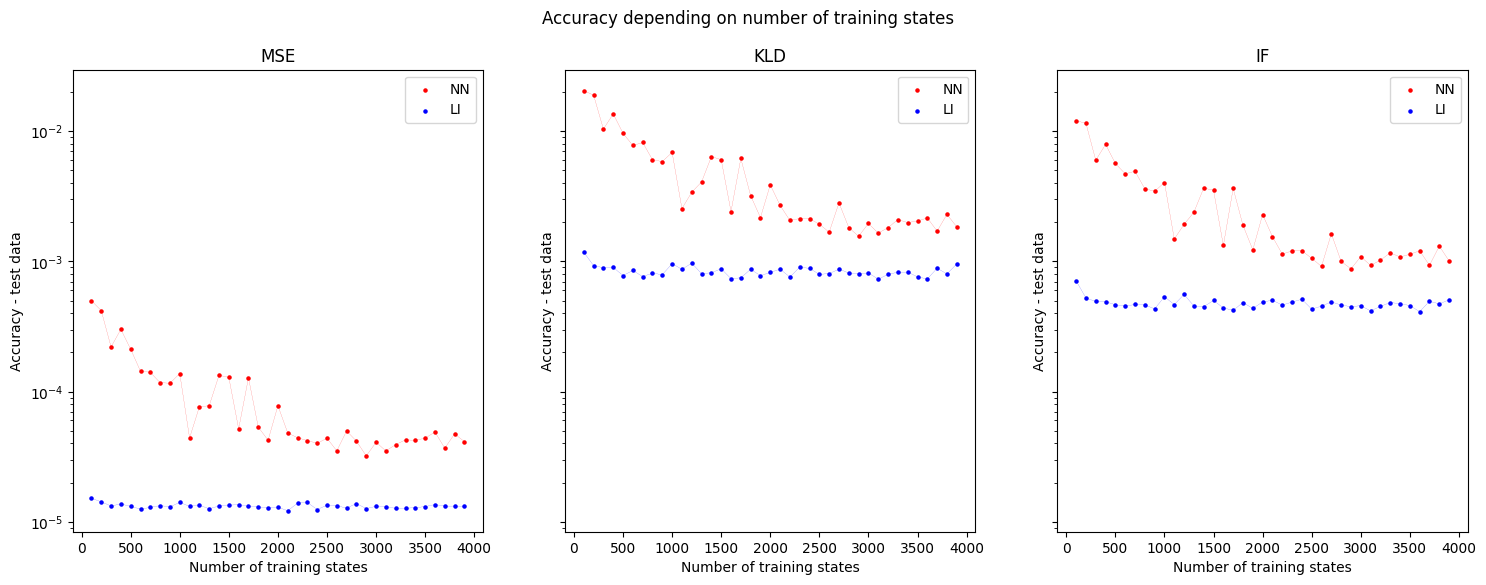

In [ ]:
nQubit = 3
layers = [40,40,2**nQubit]
num_epochs = 300
batch_size = 100
learning_rate = 0.001
#training_states = 3800
test_states = 500
test_data = np.zeros((test_states,2**nQubit*2))
theta = 0
phi = 0
p = 0.15
samplesize = 10000

model = MLP(num_neurons_per_layer=layers)        # Initialize network
x_key, init_key = random.split(random.PRNGKey(0))
x = random.normal(x_key, (batch_size, 2**nQubit))                    # Batch size 100, input size 2
params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)

optimizer = optax.adam(learning_rate=learning_rate) #sgd
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

POVM = generate_POVM(theta,phi,nQubit)

training_states = np.arange(100,4000,100)
accuracies = []

for numb in tqdm(training_states):
    training_data = np.zeros((numb,2**nQubit*2))

    calibration_states_list = []
    calibration_probs_list = []
    desired_probs_list = []
    test_probs_list = []
    desired_test_probs_list = []

    for i in range(numb):
        state = generate_random_seperable_pure_state(nQubit)
        calibration_states_list.append(state)
        probs = perform_multi_qubit_measurement(state,POVM)
        noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
        noisy_probs_sampled = sampling(noisy_probs,samplesize)
        calibration_probs_list.append(noisy_probs_sampled)
        desired_probs_list.append(probs)
        for j in range(2**nQubit):
            training_data[i][j] = noisy_probs_sampled[j]
            #training_data[i][j] = noisy_probs[j]
            training_data[i][j+2**nQubit] = probs[j]

    data_loader_training = data.DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
    batched_training_input = []
    batched_training_target_outputs = []

    for batch in data_loader_training:
        inputs, targets = jnp.split(batch,2,axis=1)
        batched_training_input.append(inputs)
        batched_training_target_outputs.append(targets)

    for i in range(test_states):
        state = generate_random_seperable_pure_state(nQubit)
        probs = perform_multi_qubit_measurement(state,POVM)
        noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
        noisy_probs_sampled = sampling(noisy_probs,samplesize)
        test_probs_list.append(noisy_probs_sampled)
        desired_test_probs_list.append(probs)
        for j in range(2**nQubit):
            test_data[i][j] = noisy_probs_sampled[j]
            #test_data[i][j] = noisy_probs[j]
            test_data[i][j+2**nQubit] = probs[j]

    data_loader_test = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
    batched_test_input = []
    batched_test_target_outputs = []

    for batch in data_loader_test:
        inputs, targets = jnp.split(batch,2,axis=1)
        batched_test_input.append(inputs)
        batched_test_target_outputs.append(targets)

    batched_tr_inp = jnp.asarray(batched_training_input)
    batched_tr_tar_out = jnp.asarray(batched_training_target_outputs)
    batched_test_inp = jnp.asarray(batched_test_input)
    batched_test_tar_out = jnp.asarray(batched_test_target_outputs)

    calibration_states = np.asarray(calibration_states_list)
    calibration_probs = np.asarray(calibration_probs_list)
    desired_probs = np.asarray(desired_probs_list)
    test_probs = np.asarray(test_probs_list)
    desired_test = np.asarray(desired_test_probs_list)

    L_inv3, POVM3, P3, MSE_data_LI3, KLD_data_LI3, IF_data_LI3 = linear_inversion(nQubit,calibration_states,calibration_probs,POVM,p,samplesize,desired_probs,test_probs,desired_test)
    trained_model_state3, MSE_data3, KLD_data3, IF_data3 = train_model(model_state, batched_tr_inp, batched_tr_tar_out,
                                                                  batched_test_inp, batched_test_tar_out,
                                                                  nQubit=nQubit, num_epochs = num_epochs)

    accuracies.append([[MSE_data3,MSE_data_LI3],[KLD_data3,KLD_data_LI3],[IF_data3,IF_data_LI3]])

MSE_acc3 = []
MSE_acc_LI3 = []
KLD_acc3 = []
KLD_acc_LI3 = []
IF_acc3 = []
IF_acc_LI3 = []

for element in accuracies:
    MSE_acc3.append(element[0][0][0][-1])
    MSE_acc_LI3.append(element[0][1][0])
    KLD_acc3.append(element[1][0][0][-1])
    KLD_acc_LI3.append(element[1][1][0])
    IF_acc3.append(element[2][0][0][-1])
    IF_acc_LI3.append(element[2][1][0])

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axs[0].scatter(training_states,MSE_acc3,s=5,label="NN",color="red")
axs[0].plot(training_states,MSE_acc3,color="red",linewidth=0.1)
axs[0].scatter(training_states,MSE_acc_LI3,s=5,label="LI",color="blue")
axs[0].plot(training_states,MSE_acc_LI3,color="blue",linewidth=0.1)
axs[0].set_xlabel('Number of training states')
axs[0].set_ylabel('Accuracy - test data')
axs[0].set_yscale('log')
axs[0].set_title('MSE')
axs[0].legend()
axs[1].scatter(training_states,KLD_acc3,s=5,label="NN",color="red")
axs[1].plot(training_states,KLD_acc3,color="red",linewidth=0.1)
axs[1].scatter(training_states,KLD_acc_LI3,s=5,label="LI",color="blue")
axs[1].plot(training_states,KLD_acc_LI3,color="blue",linewidth=0.1)
axs[1].set_xlabel('Number of training states')
axs[1].set_ylabel('Accuracy - test data')
axs[1].set_yscale('log')
axs[1].set_title('KLD')
axs[1].legend()
axs[2].scatter(training_states,IF_acc3,s=5,label="NN",color="red")
axs[2].plot(training_states,IF_acc3,color="red",linewidth=0.1)
axs[2].scatter(training_states,IF_acc_LI3,s=5,label="LI",color="blue")
axs[2].plot(training_states,IF_acc_LI3,color="blue",linewidth=0.1)
axs[2].set_xlabel('Number of training states')
axs[2].set_ylabel('Accuracy - test data')
axs[2].set_yscale('log')
axs[2].set_title('IF')
axs[2].legend()
fig.suptitle('Accuracy depending on number of training states')

  0%|          | 0/26 [00:00<?, ?it/s]

<ipython-input-21-9391498e900d>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  training_data[i][j+2**nQubit] = probs[j]
<ipython-input-21-9391498e900d>:71: ComplexWarning: Casting complex values to real discards the imaginary part
  test_data[i][j+2**nQubit] = probs[j]


loop number: 0, distance: 0.0484798011757556
loop number: 50, distance: 0.000979369057058789
loop number: 100, distance: 0.0004968732105125794
loop number: 150, distance: 0.0003190018355639075
loop number: 200, distance: 0.00022630482953719456
loop number: 250, distance: 0.00017046858667510025
loop number: 300, distance: 0.00013381410988265067
loop number: 350, distance: 0.00010822624145869815
loop number: 400, distance: 8.951137764171546e-05
loop number: 450, distance: 7.53212767794675e-05
loop number: 500, distance: 6.425424682796417e-05
loop number: 550, distance: 5.5427375475482245e-05
loop number: 600, distance: 4.8258555909800964e-05
loop number: 650, distance: 4.2348908404790803e-05
loop number: 700, distance: 3.741607645015898e-05
loop number: 750, distance: 3.325463309494083e-05
loop number: 800, distance: 2.9711610579752124e-05
loop number: 850, distance: 2.6670826294439718e-05
loop number: 900, distance: 2.404252231522723e-05
loop number: 950, distance: 2.1756325310780565e-0

<ipython-input-15-ea805b2e5879>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  L[j][i] = POVM_recon[i][j][j]


  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.02475057276263889
loop number: 50, distance: 0.0007090965010785729
loop number: 100, distance: 0.00040865103897624107
loop number: 150, distance: 0.0002779831550158876
loop number: 200, distance: 0.00020409627932543376
loop number: 250, distance: 0.00015671679228788368
loop number: 300, distance: 0.00012404489079690975
loop number: 350, distance: 0.0001004500846773884
loop number: 400, distance: 8.284517696576933e-05
loop number: 450, distance: 6.937088428282654e-05
loop number: 500, distance: 5.8837310106819813e-05
loop number: 550, distance: 5.045142555657763e-05
loop number: 600, distance: 4.366873671065929e-05
loop number: 650, distance: 3.810623016954755e-05
loop number: 700, distance: 3.34887071031532e-05
loop number: 750, distance: 2.9614581990258847e-05
loop number: 800, distance: 2.6333541103193702e-05
loop number: 850, distance: 2.3531646871268843e-05
loop number: 900, distance: 2.1121222652222153e-05
loop number: 950, distance: 1.903386404046614e-

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.01856909846311313
loop number: 50, distance: 0.0005410926998574727
loop number: 100, distance: 0.00030745610702971675
loop number: 150, distance: 0.00020765126099801034
loop number: 200, distance: 0.00015159823795467134
loop number: 250, distance: 0.00011582113220726524
loop number: 300, distance: 9.128027694508795e-05
loop number: 350, distance: 7.363199363104214e-05
loop number: 400, distance: 6.048965533759354e-05
loop number: 450, distance: 5.04297131771127e-05
loop number: 500, distance: 4.255481682902416e-05
loop number: 550, distance: 3.6275147435507e-05
loop number: 600, distance: 3.1189447462243225e-05
loop number: 650, distance: 2.7016552294823926e-05
loop number: 700, distance: 2.3554298611121332e-05
loop number: 750, distance: 2.0653998410971435e-05
loop number: 800, distance: 1.820409776047995e-05
loop number: 850, distance: 1.6119428263430574e-05
loop number: 900, distance: 1.4333960693739876e-05
loop number: 950, distance: 1.2795808428831172e-

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.014141939156458769
loop number: 50, distance: 0.00046839866217906757
loop number: 100, distance: 0.00025837963750399815
loop number: 150, distance: 0.00017089641882959047
loop number: 200, distance: 0.0001227307397595859
loop number: 250, distance: 9.24451202884729e-05
loop number: 300, distance: 7.189853569341702e-05
loop number: 350, distance: 5.725421585518616e-05
loop number: 400, distance: 4.644344767636332e-05
loop number: 450, distance: 3.8246170179684295e-05
loop number: 500, distance: 3.189601308663728e-05
loop number: 550, distance: 2.6888733239711194e-05
loop number: 600, distance: 2.2880511313993032e-05
loop number: 650, distance: 1.963011672706201e-05
loop number: 700, distance: 1.6964233775336256e-05
loop number: 750, distance: 1.4755795018114269e-05
loop number: 800, distance: 1.2909984480703916e-05
loop number: 850, distance: 1.1354943105302922e-05
loop number: 900, distance: 1.0035450267579027e-05
loop number: 950, distance: 8.90853973337369

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.012910980773601767
loop number: 50, distance: 0.0004030271063875837
loop number: 100, distance: 0.00022363593989802163
loop number: 150, distance: 0.00014856559083815233
loop number: 200, distance: 0.00010629276216218663
loop number: 250, distance: 7.941888811067293e-05
loop number: 300, distance: 6.117555553171415e-05
loop number: 350, distance: 4.824058657531885e-05
loop number: 400, distance: 3.876652340883617e-05
loop number: 450, distance: 3.1645201455817996e-05
loop number: 500, distance: 2.6176443115044228e-05
loop number: 550, distance: 2.190010298755599e-05
loop number: 600, distance: 1.8503993649918882e-05
loop number: 650, distance: 1.577053223114254e-05
loop number: 700, distance: 1.354449689025945e-05
loop number: 750, distance: 1.1712868152341285e-05
loop number: 800, distance: 1.0191857305177469e-05
loop number: 850, distance: 8.918345388319521e-06
loop number: 900, distance: 7.844103278861166e-06
loop number: 950, distance: 6.931808274119922e

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.012073105180437022
loop number: 50, distance: 0.00036351197838424624
loop number: 100, distance: 0.00019810551241022703
loop number: 150, distance: 0.00012870058025633567
loop number: 200, distance: 9.051692776743682e-05
loop number: 250, distance: 6.669503823777849e-05
loop number: 300, distance: 5.0735368215075734e-05
loop number: 350, distance: 3.9526312454397026e-05
loop number: 400, distance: 3.137700721472821e-05
loop number: 450, distance: 2.529124128075097e-05
loop number: 500, distance: 2.0647419439085688e-05
loop number: 550, distance: 1.7040271334623877e-05
loop number: 600, distance: 1.419609306062691e-05
loop number: 650, distance: 1.1924588682326101e-05
loop number: 700, distance: 1.0090184246350637e-05
loop number: 750, distance: 8.594260339852608e-06
loop number: 800, distance: 7.363777937807023e-06
loop number: 850, distance: 6.343787871169044e-06
loop number: 900, distance: 5.492375192916406e-06
loop number: 950, distance: 4.777172740115314

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.01030473670505794
loop number: 50, distance: 0.0003273121681321724
loop number: 100, distance: 0.0001788513784888653
loop number: 150, distance: 0.00011773897617300298
loop number: 200, distance: 8.372970430866571e-05
loop number: 250, distance: 6.207635709385284e-05
loop number: 300, distance: 4.729887974879403e-05
loop number: 350, distance: 3.677642685060483e-05
loop number: 400, distance: 2.905718949765842e-05
loop number: 450, distance: 2.3263634959250374e-05
loop number: 500, distance: 1.8834480290019286e-05
loop number: 550, distance: 1.5395934045271915e-05
loop number: 600, distance: 1.2691214195699666e-05
loop number: 650, distance: 1.0539423926815139e-05
loop number: 700, distance: 8.810407329868569e-06
loop number: 750, distance: 7.408805930591862e-06
loop number: 800, distance: 6.263645095364598e-06
loop number: 850, distance: 5.321360107988912e-06
loop number: 900, distance: 4.541023724544674e-06
loop number: 950, distance: 3.891017558916943e-06

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.01052402250059063
loop number: 50, distance: 0.00031522256701019947
loop number: 100, distance: 0.0001705715027794888
loop number: 150, distance: 0.00011081436965145697
loop number: 200, distance: 7.768678058494002e-05
loop number: 250, distance: 5.6753008903913e-05
loop number: 300, distance: 4.260145286967089e-05
loop number: 350, distance: 3.26323473004814e-05
loop number: 400, distance: 2.5402969194752345e-05
loop number: 450, distance: 2.0041607692836448e-05
loop number: 500, distance: 1.5992176821012925e-05
loop number: 550, distance: 1.288612388493397e-05
loop number: 600, distance: 1.0471932013661221e-05
loop number: 650, distance: 8.573804528308491e-06
loop number: 700, distance: 7.066343011964671e-06
loop number: 750, distance: 5.858492927000597e-06
loop number: 800, distance: 4.883084673168625e-06
loop number: 850, distance: 4.089862395151222e-06
loop number: 900, distance: 3.440743856258028e-06
loop number: 950, distance: 2.9065392296389766e-06
l

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.008755960598797116
loop number: 50, distance: 0.00029327670227778896
loop number: 100, distance: 0.00015600710379094128
loop number: 150, distance: 0.0001006612457944925
loop number: 200, distance: 7.050121951410176e-05
loop number: 250, distance: 5.160842112576612e-05
loop number: 300, distance: 3.884691534664916e-05
loop number: 350, distance: 2.9815421331971602e-05
loop number: 400, distance: 2.321873899686781e-05
loop number: 450, distance: 1.8289094776221634e-05
loop number: 500, distance: 1.4540335123540468e-05
loop number: 550, distance: 1.1649638458872322e-05
loop number: 600, distance: 9.394939614949273e-06
loop number: 650, distance: 7.619286996844247e-06
loop number: 700, distance: 6.209333876892398e-06
loop number: 750, distance: 5.081761504704952e-06
loop number: 800, distance: 4.174401012801603e-06
loop number: 850, distance: 3.4402620444066866e-06
loop number: 900, distance: 2.843423010263682e-06
loop number: 950, distance: 2.3561474661632684e

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.008269567394899766
loop number: 50, distance: 0.0002748847691433799
loop number: 100, distance: 0.00014641868479631933
loop number: 150, distance: 9.40425577865434e-05
loop number: 200, distance: 6.538127014666918e-05
loop number: 250, distance: 4.744522053492548e-05
loop number: 300, distance: 3.539465101218088e-05
loop number: 350, distance: 2.6934927841028167e-05
loop number: 400, distance: 2.0812707663214804e-05
loop number: 450, distance: 1.6280461073936386e-05
loop number: 500, distance: 1.2865023708401334e-05
loop number: 550, distance: 1.0253714921189797e-05
loop number: 600, distance: 8.233007087560838e-06
loop number: 650, distance: 6.653233211726397e-06
loop number: 700, distance: 5.407225767590763e-06
loop number: 750, distance: 4.416863952830175e-06
loop number: 800, distance: 3.6243253376836946e-06
loop number: 850, distance: 2.986243479988874e-06
loop number: 900, distance: 2.4697170985572408e-06
loop number: 950, distance: 2.049530296075356e-

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.008227848435650402
loop number: 50, distance: 0.0002544396798601495
loop number: 100, distance: 0.00013630592129696973
loop number: 150, distance: 8.779250115667184e-05
loop number: 200, distance: 6.073671612119759e-05
loop number: 250, distance: 4.3624794378637056e-05
loop number: 300, distance: 3.211070500452385e-05
loop number: 350, distance: 2.4063918299619353e-05
loop number: 400, distance: 1.8287620813877556e-05
loop number: 450, distance: 1.4055442924066544e-05
loop number: 500, distance: 1.0903564193949288e-05
loop number: 550, distance: 8.52461005007354e-06
loop number: 600, distance: 6.708890183599136e-06
loop number: 650, distance: 5.309936408216882e-06
loop number: 700, distance: 4.223397973092014e-06
loop number: 750, distance: 3.3736658574927094e-06
loop number: 800, distance: 2.7051528142560967e-06
loop number: 850, distance: 2.176470837275227e-06
loop number: 900, distance: 1.7564616151474066e-06
loop number: 950, distance: 1.421440089292076e

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.007977154793746692
loop number: 50, distance: 0.0002462039710653702
loop number: 100, distance: 0.00013395568545310836
loop number: 150, distance: 8.674708230043451e-05
loop number: 200, distance: 6.019491323241153e-05
loop number: 250, distance: 4.3367192316875736e-05
loop number: 300, distance: 3.203257144088014e-05
loop number: 350, distance: 2.4096596134791136e-05
loop number: 400, distance: 1.8383634928322646e-05
loop number: 450, distance: 1.4183072692160574e-05
loop number: 500, distance: 1.1042693052091524e-05
loop number: 550, distance: 8.663198316783781e-06
loop number: 600, distance: 6.8402237764671006e-06
loop number: 650, distance: 5.430653725231814e-06
loop number: 700, distance: 4.332161424290236e-06
loop number: 750, distance: 3.4703086985282966e-06
loop number: 800, distance: 2.790151081589594e-06
loop number: 850, distance: 2.2506265024184104e-06
loop number: 900, distance: 1.8207178167281682e-06
loop number: 950, distance: 1.47677653055434

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.00742833497975444
loop number: 50, distance: 0.00023820989402749708
loop number: 100, distance: 0.0001285632181381059
loop number: 150, distance: 8.304707645491867e-05
loop number: 200, distance: 5.746813941943209e-05
loop number: 250, distance: 4.1237309899061076e-05
loop number: 300, distance: 3.029081834633085e-05
loop number: 350, distance: 2.2626286763873674e-05
loop number: 400, distance: 1.7118454500930294e-05
loop number: 450, distance: 1.3083351474193982e-05
loop number: 500, distance: 1.0082560392281528e-05
loop number: 550, distance: 7.823955422292186e-06
loop number: 600, distance: 6.107052514505814e-06
loop number: 650, distance: 4.791030315836359e-06
loop number: 700, distance: 3.7751073804461295e-06
loop number: 750, distance: 2.9860368026843583e-06
loop number: 800, distance: 2.369888942538569e-06
loop number: 850, distance: 1.8865146622289933e-06
loop number: 900, distance: 1.5057360105252437e-06
loop number: 950, distance: 1.204678796823000

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.006928780659227317
loop number: 50, distance: 0.00022212780508275117
loop number: 100, distance: 0.00011822981987595303
loop number: 150, distance: 7.619342001306218e-05
loop number: 200, distance: 5.274767793616128e-05
loop number: 250, distance: 3.78347073495284e-05
loop number: 300, distance: 2.7738746463813743e-05
loop number: 350, distance: 2.0650396790745074e-05
loop number: 400, distance: 1.5550547556335666e-05
loop number: 450, distance: 1.1815574217840431e-05
loop number: 500, distance: 9.042769782633111e-06
loop number: 550, distance: 6.961989778388482e-06
loop number: 600, distance: 5.386794518507612e-06
loop number: 650, distance: 4.185654672113375e-06
loop number: 700, distance: 3.264139756271792e-06
loop number: 750, distance: 2.55347696219269e-06
loop number: 800, distance: 2.0029786465929133e-06
loop number: 850, distance: 1.5749074820940818e-06
loop number: 900, distance: 1.2409241231648174e-06
loop number: 950, distance: 9.79587826850712e-0

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.007204688385168141
loop number: 50, distance: 0.00022057899776780287
loop number: 100, distance: 0.00011753155420347917
loop number: 150, distance: 7.555110054546178e-05
loop number: 200, distance: 5.217261765975121e-05
loop number: 250, distance: 3.732891505754302e-05
loop number: 300, distance: 2.7298329507670378e-05
loop number: 350, distance: 2.0269981281825285e-05
loop number: 400, distance: 1.5223805719067896e-05
loop number: 450, distance: 1.1535847564385047e-05
loop number: 500, distance: 8.80365523453413e-06
loop number: 550, distance: 6.757686402116447e-06
loop number: 600, distance: 5.212231640406275e-06
loop number: 650, distance: 4.0364851815453585e-06
loop number: 700, distance: 3.1366693633786795e-06
loop number: 750, distance: 2.4445730403218106e-06
loop number: 800, distance: 1.9099808583842524e-06
loop number: 850, distance: 1.4955493089643992e-06
loop number: 900, distance: 1.173267537407206e-06
loop number: 950, distance: 9.21970208825049

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.006735973916380319
loop number: 50, distance: 0.00021363911288413217
loop number: 100, distance: 0.00011549159793090886
loop number: 150, distance: 7.446653672234683e-05
loop number: 200, distance: 5.1379331463817294e-05
loop number: 250, distance: 3.6700610794260585e-05
loop number: 300, distance: 2.679775236297636e-05
loop number: 350, distance: 1.9876042989628714e-05
loop number: 400, distance: 1.4919848862760423e-05
loop number: 450, distance: 1.1307406222985493e-05
loop number: 500, distance: 8.637860126317035e-06
loop number: 550, distance: 6.643080035369249e-06
loop number: 600, distance: 5.138716087958706e-06
loop number: 650, distance: 3.99529655990008e-06
loop number: 700, distance: 3.120333981707934e-06
loop number: 750, distance: 2.4468324796980185e-06
loop number: 800, distance: 1.9256893834671537e-06
loop number: 850, distance: 1.52055315161744e-06
loop number: 900, distance: 1.2042763189959525e-06
loop number: 950, distance: 9.564291053215636e

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.006433334010336308
loop number: 50, distance: 0.00020114081868590728
loop number: 100, distance: 0.00010573576325707044
loop number: 150, distance: 6.714288128544757e-05
loop number: 200, distance: 4.582663993551793e-05
loop number: 250, distance: 3.239516124593714e-05
loop number: 300, distance: 2.3389409252608052e-05
loop number: 350, distance: 1.713455556966462e-05
loop number: 400, distance: 1.2688997976714118e-05
loop number: 450, distance: 9.47688701079066e-06
loop number: 500, distance: 7.126884354402275e-06
loop number: 550, distance: 5.390629800843746e-06
loop number: 600, distance: 4.09753624806122e-06
loop number: 650, distance: 3.128048705887712e-06
loop number: 700, distance: 2.3970453770174377e-06
loop number: 750, distance: 1.8431472499976332e-06
loop number: 800, distance: 1.421631893524323e-06
loop number: 850, distance: 1.0996275358564988e-06
loop number: 900, distance: 8.527926446529948e-07
loop number: 950, distance: 6.629864860231134e-07

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0058691441888154535
loop number: 50, distance: 0.00020383201403869448
loop number: 100, distance: 0.00010832972990363612
loop number: 150, distance: 6.941288642917818e-05
loop number: 200, distance: 4.767494032743852e-05
loop number: 250, distance: 3.385533623884795e-05
loop number: 300, distance: 2.4528214633419242e-05
loop number: 350, distance: 1.801565236585114e-05
loop number: 400, distance: 1.3366047557947232e-05
loop number: 450, distance: 9.993610943076933e-06
loop number: 500, distance: 7.5184121414814796e-06
loop number: 550, distance: 5.684947365338812e-06
loop number: 600, distance: 4.316791906560782e-06
loop number: 650, distance: 3.2896716586387775e-06
loop number: 700, distance: 2.5146804535533543e-06
loop number: 750, distance: 1.9274243048126697e-06
loop number: 800, distance: 1.4807922187096787e-06
loop number: 850, distance: 1.1400296266071665e-06
loop number: 900, distance: 8.79317723638658e-07
loop number: 950, distance: 6.79361791154960

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0061534671538110534
loop number: 50, distance: 0.00019676587012234186
loop number: 100, distance: 0.00010488408069397324
loop number: 150, distance: 6.698670269125737e-05
loop number: 200, distance: 4.581792037765191e-05
loop number: 250, distance: 3.241058879438043e-05
loop number: 300, distance: 2.3395558609202245e-05
loop number: 350, distance: 1.7122631648740728e-05
loop number: 400, distance: 1.2659087746790047e-05
loop number: 450, distance: 9.432431449528384e-06
loop number: 500, distance: 7.072218302574585e-06
loop number: 550, distance: 5.32985966080612e-06
loop number: 600, distance: 4.034093342849514e-06
loop number: 650, distance: 3.0645824974113986e-06
loop number: 700, distance: 2.335474585598462e-06
loop number: 750, distance: 1.7847724428142157e-06
loop number: 800, distance: 1.3672612371478927e-06
loop number: 850, distance: 1.0496936127728746e-06
loop number: 900, distance: 8.074519410207534e-07
loop number: 950, distance: 6.22199901863909e

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.006041709887699632
loop number: 50, distance: 0.00019184297645962562
loop number: 100, distance: 0.00010183838806429199
loop number: 150, distance: 6.479309443685756e-05
loop number: 200, distance: 4.415787494779155e-05
loop number: 250, distance: 3.115351096001074e-05
loop number: 300, distance: 2.2445851577644497e-05
loop number: 350, distance: 1.6402953689713467e-05
loop number: 400, distance: 1.2110049071421816e-05
loop number: 450, distance: 9.010232869604883e-06
loop number: 500, distance: 6.745048974377223e-06
loop number: 550, distance: 5.0745931059060605e-06
loop number: 600, distance: 3.833762923345616e-06
loop number: 650, distance: 2.9065904859945843e-06
loop number: 700, distance: 2.2103537984478606e-06
loop number: 750, distance: 1.6853309184823936e-06
loop number: 800, distance: 1.2879848762122355e-06
loop number: 850, distance: 9.86322182173848e-07
loop number: 900, distance: 7.566729070982204e-07
loop number: 950, distance: 5.814238097578744

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.0055660418922256335
loop number: 50, distance: 0.00018323536841177853
loop number: 100, distance: 9.836207757973637e-05
loop number: 150, distance: 6.28700097029627e-05
loop number: 200, distance: 4.288460362937641e-05
loop number: 250, distance: 3.0211601457811984e-05
loop number: 300, distance: 2.1702646005078803e-05
loop number: 350, distance: 1.579604527678524e-05
loop number: 400, distance: 1.1606218042837057e-05
loop number: 450, distance: 8.58924593538359e-06
loop number: 500, distance: 6.392876771180607e-06
loop number: 550, distance: 4.780462541581313e-06
loop number: 600, distance: 3.5888400271062826e-06
loop number: 650, distance: 2.703373070052374e-06
loop number: 700, distance: 2.0423750041274455e-06
loop number: 750, distance: 1.5469972143903511e-06
loop number: 800, distance: 1.1744703639895936e-06
loop number: 850, distance: 8.934854460652561e-07
loop number: 900, distance: 6.809828077261677e-07
loop number: 950, distance: 5.19889628851064e-0

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.005690319657503126
loop number: 50, distance: 0.0001795863977911219
loop number: 100, distance: 9.598527044454563e-05
loop number: 150, distance: 6.144831926745233e-05
loop number: 200, distance: 4.2008973326561596e-05
loop number: 250, distance: 2.9621474442602447e-05
loop number: 300, distance: 2.1272058821546584e-05
loop number: 350, distance: 1.5465525820773047e-05
loop number: 400, distance: 1.1345338987678372e-05
loop number: 450, distance: 8.380295204949023e-06
loop number: 500, distance: 6.224173102172887e-06
loop number: 550, distance: 4.643594047120118e-06
loop number: 600, distance: 3.477436055687391e-06
loop number: 650, distance: 2.6124799620238646e-06
loop number: 700, distance: 1.9680855740249466e-06
loop number: 750, distance: 1.4862018558474896e-06
loop number: 800, distance: 1.1246772525995423e-06
loop number: 850, distance: 8.526860635599729e-07
loop number: 900, distance: 6.475497622010159e-07
loop number: 950, distance: 4.92498374607701e

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.00571738446943411
loop number: 50, distance: 0.0001775265901261661
loop number: 100, distance: 9.560157217554769e-05
loop number: 150, distance: 6.141764498999431e-05
loop number: 200, distance: 4.2128333068342614e-05
loop number: 250, distance: 2.9822857499349075e-05
loop number: 300, distance: 2.1506529631065584e-05
loop number: 350, distance: 1.5700747751745954e-05
loop number: 400, distance: 1.1563380842634284e-05
loop number: 450, distance: 8.573152815627173e-06
loop number: 500, distance: 6.389779828913226e-06
loop number: 550, distance: 4.783060048390942e-06
loop number: 600, distance: 3.593351736815502e-06
loop number: 650, distance: 2.7079499577220725e-06
loop number: 700, distance: 2.046216062273916e-06
loop number: 750, distance: 1.5498532159647042e-06
loop number: 800, distance: 1.176365167687773e-06
loop number: 850, distance: 8.945617332428188e-07
loop number: 900, distance: 6.814194768154494e-07
loop number: 950, distance: 5.198602508316748e-0

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.005402205784243998
loop number: 50, distance: 0.00017213269167000794
loop number: 100, distance: 9.028947957240706e-05
loop number: 150, distance: 5.721155377070027e-05
loop number: 200, distance: 3.8987069203102366e-05
loop number: 250, distance: 2.7507199246608737e-05
loop number: 300, distance: 1.9794913070450473e-05
loop number: 350, distance: 1.4425186045386699e-05
loop number: 400, distance: 1.0603671059689731e-05
loop number: 450, distance: 7.844451721078125e-06
loop number: 500, distance: 5.831970483704361e-06
loop number: 550, distance: 4.353081964958598e-06
loop number: 600, distance: 3.25995830794933e-06
loop number: 650, distance: 2.4481721102595097e-06
loop number: 700, distance: 1.842967059545553e-06
loop number: 750, distance: 1.390287185403088e-06
loop number: 800, distance: 1.0507354661939776e-06
loop number: 850, distance: 7.95414648345929e-07
loop number: 900, distance: 6.030162841244308e-07
loop number: 950, distance: 4.577572330284756e-0

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.005519117088079761
loop number: 50, distance: 0.00016317115923421497
loop number: 100, distance: 8.613245624960599e-05
loop number: 150, distance: 5.488461988853941e-05
loop number: 200, distance: 3.750347413640477e-05
loop number: 250, distance: 2.6465861923400987e-05
loop number: 300, distance: 1.9014734243839646e-05
loop number: 350, distance: 1.3816543200453244e-05
loop number: 400, distance: 1.0117679075620339e-05
loop number: 450, distance: 7.451563861880364e-06
loop number: 500, distance: 5.512491476201206e-06
loop number: 550, distance: 4.092768904209553e-06
loop number: 600, distance: 3.0478840811342893e-06
loop number: 650, distance: 2.2756289320606617e-06
loop number: 700, distance: 1.702862321348934e-06
loop number: 750, distance: 1.2767795244270084e-06
loop number: 800, distance: 9.58992728402969e-07
loop number: 850, distance: 7.214374175449917e-07
loop number: 900, distance: 5.434997739325625e-07
loop number: 950, distance: 4.0997816793509435e

  0%|          | 0/300 [00:00<?, ?it/s]

loop number: 0, distance: 0.005207826110112403
loop number: 50, distance: 0.00016494516800135014
loop number: 100, distance: 8.814145660049364e-05
loop number: 150, distance: 5.6462802937604896e-05
loop number: 200, distance: 3.855404418283657e-05
loop number: 250, distance: 2.712094664531054e-05
loop number: 300, distance: 1.9415998010791115e-05
loop number: 350, distance: 1.406384729393082e-05
loop number: 400, distance: 1.0272876053971973e-05
loop number: 450, distance: 7.551230067721704e-06
loop number: 500, distance: 5.578036593582064e-06
loop number: 550, distance: 4.136832316977699e-06
loop number: 600, distance: 3.0780701162381368e-06
loop number: 650, distance: 2.296625895669063e-06
loop number: 700, distance: 1.7176389387336225e-06
loop number: 750, distance: 1.2872662940875176e-06
loop number: 800, distance: 9.664764869905589e-07
loop number: 850, distance: 7.267948652663633e-07
loop number: 900, distance: 5.473392389590443e-07
loop number: 950, distance: 4.127279919060452e-

  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0.98, 'Accuracy depending on number of training states')

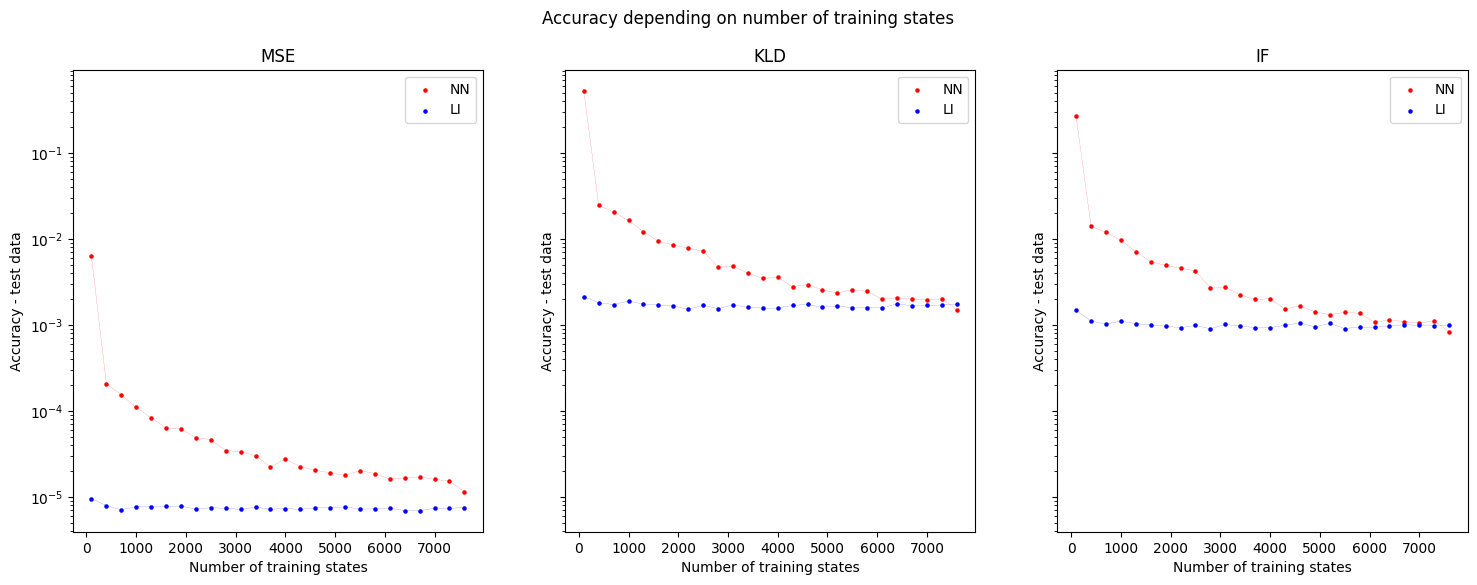

In [ ]:
nQubit = 4
layers = [80,80,80,80,80,80,80,2**nQubit]
num_epochs = 300
batch_size = 100
learning_rate = 5*10**-5
#training_states = 7800
test_states = 500
#training_data = np.zeros((training_states,2**nQubit*2))
test_data = np.zeros((test_states,2**nQubit*2))
theta = 0
phi = 0
p = 0.15
samplesize = 10000

model = MLP(num_neurons_per_layer=layers)        # Initialize network
x_key, init_key = random.split(random.PRNGKey(0))
x = random.normal(x_key, (batch_size, 2**nQubit))                    # Batch size 100, input size 2
params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)

optimizer = optax.adam(learning_rate=learning_rate) #sgd
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

POVM = generate_POVM(theta,phi,nQubit)

training_states = np.arange(100,7900,300)
accuracies = []

for numb in tqdm(training_states):
    training_data = np.zeros((numb,2**nQubit*2))

    calibration_states_list = []
    calibration_probs_list = []
    desired_probs_list = []
    test_probs_list = []
    desired_test_probs_list = []

    for i in range(numb):
        state = generate_random_seperable_pure_state(nQubit)
        calibration_states_list.append(state)
        probs = perform_multi_qubit_measurement(state,POVM)
        noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
        noisy_probs_sampled = sampling(noisy_probs,samplesize)
        calibration_probs_list.append(noisy_probs_sampled)
        desired_probs_list.append(probs)
        for j in range(2**nQubit):
            training_data[i][j] = noisy_probs_sampled[j]
            #training_data[i][j] = noisy_probs[j]
            training_data[i][j+2**nQubit] = probs[j]

    data_loader_training = data.DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
    batched_training_input = []
    batched_training_target_outputs = []

    for batch in data_loader_training:
        inputs, targets = jnp.split(batch,2,axis=1)
        batched_training_input.append(inputs)
        batched_training_target_outputs.append(targets)

    for i in range(test_states):
        state = generate_random_seperable_pure_state(nQubit)
        probs = perform_multi_qubit_measurement(state,POVM)
        noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
        noisy_probs_sampled = sampling(noisy_probs,samplesize)
        test_probs_list.append(noisy_probs_sampled)
        desired_test_probs_list.append(probs)
        for j in range(2**nQubit):
            test_data[i][j] = noisy_probs_sampled[j]
            #test_data[i][j] = noisy_probs[j]
            test_data[i][j+2**nQubit] = probs[j]

    data_loader_test = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
    batched_test_input = []
    batched_test_target_outputs = []

    for batch in data_loader_test:
        inputs, targets = jnp.split(batch,2,axis=1)
        batched_test_input.append(inputs)
        batched_test_target_outputs.append(targets)

    batched_tr_inp = jnp.asarray(batched_training_input)
    batched_tr_tar_out = jnp.asarray(batched_training_target_outputs)
    batched_test_inp = jnp.asarray(batched_test_input)
    batched_test_tar_out = jnp.asarray(batched_test_target_outputs)

    calibration_states = np.asarray(calibration_states_list)
    calibration_probs = np.asarray(calibration_probs_list)
    desired_probs = np.asarray(desired_probs_list)
    test_probs = np.asarray(test_probs_list)
    desired_test = np.asarray(desired_test_probs_list)

    L_inv4, POVM4, P4, MSE_data_LI4, KLD_data_LI4, IF_data_LI4 = linear_inversion(nQubit,calibration_states,calibration_probs,POVM,p,samplesize,desired_probs,test_probs,desired_test)
    trained_model_state4, MSE_data4, KLD_data4, IF_data4 = train_model(model_state, batched_tr_inp, batched_tr_tar_out,
                                                                  batched_test_inp, batched_test_tar_out,
                                                                  nQubit=nQubit, num_epochs = num_epochs)

    accuracies.append([[MSE_data4,MSE_data_LI4],[KLD_data4,KLD_data_LI4],[IF_data4,IF_data_LI4]])

MSE_acc4 = []
MSE_acc_LI4 = []
KLD_acc4 = []
KLD_acc_LI4 = []
IF_acc4 = []
IF_acc_LI4 = []

for element in accuracies:
    MSE_acc4.append(element[0][0][0][-1])
    MSE_acc_LI4.append(element[0][1][0])
    KLD_acc4.append(element[1][0][0][-1])
    KLD_acc_LI4.append(element[1][1][0])
    IF_acc4.append(element[2][0][0][-1])
    IF_acc_LI4.append(element[2][1][0])

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axs[0].scatter(training_states,MSE_acc4,s=5,label="NN",color="red")
axs[0].plot(training_states,MSE_acc4,color="red",linewidth=0.1)
axs[0].scatter(training_states,MSE_acc_LI4,s=5,label="LI",color="blue")
axs[0].plot(training_states,MSE_acc_LI4,color="blue",linewidth=0.1)
axs[0].set_xlabel('Number of training states')
axs[0].set_ylabel('Accuracy - test data')
axs[0].set_yscale('log')
axs[0].set_title('MSE')
axs[0].legend()
axs[1].scatter(training_states,KLD_acc4,s=5,label="NN",color="red")
axs[1].plot(training_states,KLD_acc4,color="red",linewidth=0.1)
axs[1].scatter(training_states,KLD_acc_LI4,s=5,label="LI",color="blue")
axs[1].plot(training_states,KLD_acc_LI4,color="blue",linewidth=0.1)
axs[1].set_xlabel('Number of training states')
axs[1].set_ylabel('Accuracy - test data')
axs[1].set_yscale('log')
axs[1].set_title('KLD')
axs[1].legend()
axs[2].scatter(training_states,IF_acc4,s=5,label="NN",color="red")
axs[2].plot(training_states,IF_acc4,color="red",linewidth=0.1)
axs[2].scatter(training_states,IF_acc_LI4,s=5,label="LI",color="blue")
axs[2].plot(training_states,IF_acc_LI4,color="blue",linewidth=0.1)
axs[2].set_xlabel('Number of training states')
axs[2].set_ylabel('Accuracy - test data')
axs[2].set_yscale('log')
axs[2].set_title('IF')
axs[2].legend()
fig.suptitle('Accuracy depending on number of training states')

  0%|          | 0/9900 [00:00<?, ?it/s]

<ipython-input-26-a2356db3f9db>:44: ComplexWarning: Casting complex values to real discards the imaginary part
  training_data[i][j+2**nQubit] = probs[j]


  0%|          | 0/200 [00:00<?, ?it/s]

<ipython-input-26-a2356db3f9db>:56: ComplexWarning: Casting complex values to real discards the imaginary part
  test_data[i][j+2**nQubit] = probs[j]


loop number: 0, distance: 0.012631193392009552
loop number: 50, distance: 0.0004645921245399286
loop number: 100, distance: 0.00028334822688809484
loop number: 150, distance: 0.00019918592076357308
loop number: 200, distance: 0.0001498629231016861
loop number: 250, distance: 0.00011790984179330123
loop number: 300, distance: 9.569247094764779e-05
loop number: 350, distance: 7.939443708659002e-05
loop number: 400, distance: 6.695147776380189e-05
loop number: 450, distance: 5.716585747761442e-05
loop number: 500, distance: 4.929658961703109e-05
loop number: 550, distance: 4.285890500696958e-05
loop number: 600, distance: 3.752045278994947e-05
loop number: 650, distance: 3.3044476063634536e-05
loop number: 700, distance: 2.925699664102602e-05
loop number: 750, distance: 2.602691144204345e-05
loop number: 800, distance: 2.3253378644296658e-05
loop number: 850, distance: 2.0857509914690872e-05
loop number: 900, distance: 1.877671335176831e-05
loop number: 950, distance: 1.6960729488087358e-

<ipython-input-15-ea805b2e5879>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  L[j][i] = POVM_recon[i][j][j]


  0%|          | 0/300 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Accuracy')

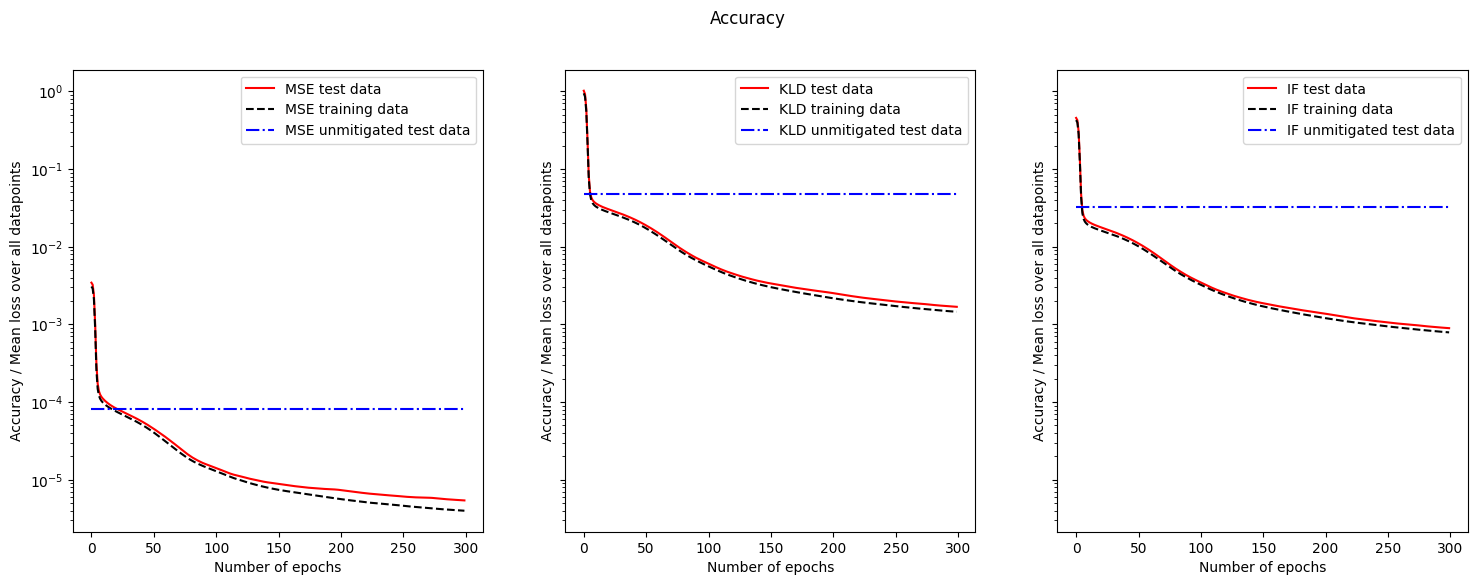

In [ ]:
nQubit = 5
layers = [160,160,160,160,160,2**nQubit]
num_epochs = 300
batch_size = 100
learning_rate = 5*10**-5
training_states = 9900 # originally 9850 but adapted to the batch size
test_states = 200
training_data = np.zeros((training_states,2**nQubit*2))
test_data = np.zeros((test_states,2**nQubit*2))
theta = 0
phi = 0
p = 0.15
samplesize = 10000

model = MLP(num_neurons_per_layer=layers)        # Initialize network
x_key, init_key = random.split(random.PRNGKey(0))
x = random.normal(x_key, (batch_size, 2**nQubit))                    # Batch size 100, input size 2
params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)

optimizer = optax.adam(learning_rate=learning_rate) #sgd
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

POVM = generate_POVM(theta,phi,nQubit)

calibration_states_list = []
calibration_probs_list = []
desired_probs_list = []
test_probs_list = []
desired_test_probs_list = []

for i in tqdm(range(training_states)):
    state = generate_random_seperable_pure_state(nQubit)
    calibration_states_list.append(state)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    noisy_probs_sampled = sampling(noisy_probs,samplesize)
    calibration_probs_list.append(noisy_probs_sampled)
    desired_probs_list.append(probs)
    for j in range(2**nQubit):
        training_data[i][j] = noisy_probs_sampled[j]
        #training_data[i][j] = noisy_probs[j]
        training_data[i][j+2**nQubit] = probs[j]

for i in tqdm(range(test_states)):
    state = generate_random_seperable_pure_state(nQubit)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    noisy_probs_sampled = sampling(noisy_probs,samplesize)
    test_probs_list.append(noisy_probs_sampled)
    desired_test_probs_list.append(probs)
    for j in range(2**nQubit):
        test_data[i][j] = noisy_probs_sampled[j]
        #test_data[i][j] = noisy_probs[j]
        test_data[i][j+2**nQubit] = probs[j]

data_loader_training = data.DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_training_input = []
batched_training_target_outputs = []

for batch in data_loader_training:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_training_input.append(inputs)
  batched_training_target_outputs.append(targets)


data_loader_test = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_test_input = []
batched_test_target_outputs = []

for batch in data_loader_test:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_test_input.append(inputs)
  batched_test_target_outputs.append(targets)

batched_tr_inp = jnp.asarray(batched_training_input)
batched_tr_tar_out = jnp.asarray(batched_training_target_outputs)
batched_test_inp = jnp.asarray(batched_test_input)
batched_test_tar_out = jnp.asarray(batched_test_target_outputs)

calibration_states = np.asarray(calibration_states_list)
calibration_probs = np.asarray(calibration_probs_list)
desired_probs = np.asarray(desired_probs_list)
test_probs = np.asarray(test_probs_list)
desired_test = np.asarray(desired_test_probs_list)

L_inv5, POVM5, P5, MSE_data_LI5, KLD_data_LI5, IF_data_LI5 = linear_inversion(nQubit,calibration_states,calibration_probs,POVM,p,samplesize,desired_probs,test_probs,desired_test)
trained_model_state5, MSE_data5, KLD_data5, IF_data5 = train_model(model_state, batched_tr_inp, batched_tr_tar_out,
                                                               batched_test_inp, batched_test_tar_out,
                                                               nQubit=nQubit, num_epochs = num_epochs)

i = np.arange(0,num_epochs)
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axs[0].plot(i,MSE_data5[0],label="MSE test data",color="red")
axs[0].plot(i,MSE_data5[1],label="MSE training data",linestyle="--",color="black")
axs[0].plot(i,MSE_data5[2],label="MSE unmitigated test data",linestyle="-.",color="blue")
axs[0].set_xlabel('Number of epochs')
axs[0].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[0].set_yscale('log')
axs[0].legend()
axs[1].plot(i,KLD_data5[0],label="KLD test data",color="red")
axs[1].plot(i,KLD_data5[1],label="KLD training data",linestyle="--",color="black")
axs[1].plot(i,KLD_data5[2],label="KLD unmitigated test data",linestyle="-.",color="blue")
axs[1].set_xlabel('Number of epochs')
axs[1].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[1].set_yscale('log')
axs[1].legend()
axs[2].plot(i,IF_data5[0],label="IF test data",color="red")
axs[2].plot(i,IF_data5[1],label="IF training data",linestyle="--",color="black")
axs[2].plot(i,IF_data5[2],label="IF unmitigated test data",linestyle="-.",color="blue")
axs[2].set_xlabel('Number of epochs')
axs[2].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[2].set_yscale('log')
axs[2].legend()
fig.suptitle('Accuracy')

In [ ]:
print(MSE_data_LI5, KLD_data_LI5, IF_data_LI5)
#print(POVM2)
for element in POVM5:
  print(np.all(np.linalg.eigvals(element) > 0))

[Array(3.7324648e-06, dtype=float32), Array(3.9007186e-06, dtype=float32)] [Array(0.00261542-0.00248387j, dtype=complex64), Array(0.00293784-0.00230111j, dtype=complex64)] [Array(0.00167097-0.00161315j, dtype=complex64), Array(0.00180024-0.00137916j, dtype=complex64)]
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


Text(0.5, 0.98, 'NN vs LI improvement')

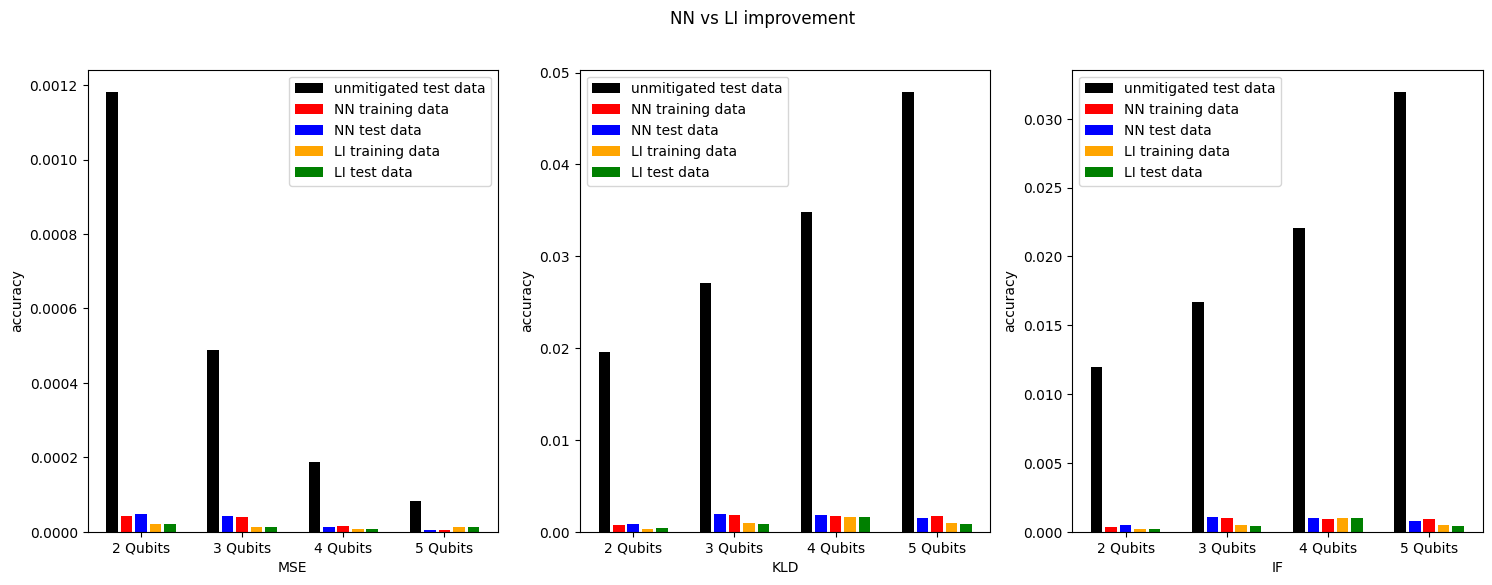

In [ ]:
labels = ["2 Qubits","3 Qubits","4 Qubits","5 Qubits"]
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

axs[0].bar(0,MSE_data2[2][-1],label="unmitigated test data",color="black")
axs[0].bar(1,MSE_data2[1][-1],label="NN training data",color="red")
axs[0].bar(2,MSE_data2[0][-1],label="NN test data",color="blue")
axs[0].bar(3,MSE_data_LI2[1],label="LI training data",color="orange")
axs[0].bar(4,MSE_data_LI2[0],label="LI test data",color="green")
axs[0].bar(7,MSE_data3[2][-1],color="black")
axs[0].bar(8,MSE_data3[1][-1],color="blue")
axs[0].bar(9,MSE_data3[0][-1],color="red")
axs[0].bar(10,MSE_data_LI3[1],color="orange")
axs[0].bar(11,MSE_data_LI3[0],color="green")
axs[0].bar(14,MSE_data4[2][-1],color="black")
axs[0].bar(15,MSE_data4[1][-1],color="blue")
axs[0].bar(16,MSE_data4[0][-1],color="red")
axs[0].bar(17,MSE_data_LI4[1],color="orange")
axs[0].bar(18,MSE_data_LI4[0],color="green")
axs[0].bar(21,MSE_data5[2][-1],color="black")
axs[0].bar(22,MSE_data5[1][-1],color="blue")
axs[0].bar(23,MSE_data5[0][-1],color="red")
axs[0].bar(24,MSE_data_LI3[1],color="orange")
axs[0].bar(25,MSE_data_LI3[0],color="green")
axs[0].set_xticks([2,9,16,23])
axs[0].set_xticklabels(labels)
axs[0].set_xlabel("MSE")
axs[0].set_ylabel("accuracy")
axs[0].legend()

axs[1].bar(0,KLD_data2[2][-1],label="unmitigated test data",color="black")
axs[1].bar(1,KLD_data2[1][-1],label="NN training data",color="red")
axs[1].bar(2,KLD_data2[0][-1],label="NN test data",color="blue")
axs[1].bar(3,KLD_data_LI2[1],label="LI training data",color="orange")
axs[1].bar(4,KLD_data_LI2[0],label="LI test data",color="green")
axs[1].bar(7,KLD_data3[2][-1],color="black")
axs[1].bar(8,KLD_data3[1][-1],color="blue")
axs[1].bar(9,KLD_data3[0][-1],color="red")
axs[1].bar(10,KLD_data_LI3[1],color="orange")
axs[1].bar(11,KLD_data_LI3[0],color="green")
axs[1].bar(14,KLD_data4[2][-1],color="black")
axs[1].bar(15,KLD_data4[1][-1],color="blue")
axs[1].bar(16,KLD_data4[0][-1],color="red")
axs[1].bar(17,KLD_data_LI4[1],color="orange")
axs[1].bar(18,KLD_data_LI4[0],color="green")
axs[1].bar(21,KLD_data5[2][-1],color="black")
axs[1].bar(22,KLD_data5[1][-1],color="blue")
axs[1].bar(23,KLD_data5[0][-1],color="red")
axs[1].bar(24,KLD_data_LI3[1],color="orange")
axs[1].bar(25,KLD_data_LI3[0],color="green")
axs[1].set_xticks([2,9,16,23])
axs[1].set_xticklabels(labels)
axs[1].set_xlabel("KLD")
axs[1].set_ylabel("accuracy")
axs[1].legend()

axs[2].bar(0,IF_data2[2][-1],label="unmitigated test data",color="black")
axs[2].bar(1,IF_data2[1][-1],label="NN training data",color="red")
axs[2].bar(2,IF_data2[0][-1],label="NN test data",color="blue")
axs[2].bar(3,IF_data_LI2[1],label="LI training data",color="orange")
axs[2].bar(4,IF_data_LI2[0],label="LI test data",color="green")
axs[2].bar(7,IF_data3[2][-1],color="black")
axs[2].bar(8,IF_data3[1][-1],color="blue")
axs[2].bar(9,IF_data3[0][-1],color="red")
axs[2].bar(10,IF_data_LI3[1],color="orange")
axs[2].bar(11,IF_data_LI3[0],color="green")
axs[2].bar(14,IF_data4[2][-1],color="black")
axs[2].bar(15,IF_data4[1][-1],color="blue")
axs[2].bar(16,IF_data4[0][-1],color="red")
axs[2].bar(17,IF_data_LI4[1],color="orange")
axs[2].bar(18,IF_data_LI4[0],color="green")
axs[2].bar(21,IF_data5[2][-1],color="black")
axs[2].bar(22,IF_data5[1][-1],color="blue")
axs[2].bar(23,IF_data5[0][-1],color="red")
axs[2].bar(24,IF_data_LI3[1],color="orange")
axs[2].bar(25,IF_data_LI3[0],color="green")
axs[2].set_xticks([2,9,16,23])
axs[2].set_xticklabels(labels)
axs[2].set_xlabel("IF")
axs[2].set_ylabel("accuracy")
axs[2].legend()

fig.suptitle('NN vs LI improvement')